In [376]:
import os
import json
from tqdm.notebook import tqdm
import pickle
import lzma
import argparse
import bz2
import re
#import zstd
from collections import defaultdict
import pandas as pd
from inference import Estimator

from shared_apis import write_file, read_file,split_labels
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from urllib.parse import urlparse

In [1017]:
#statements = [
#'My social media feed', 'General public', 'News story is interesting to me', 'Tackles an important issue', "Shouldn't be public outside science", 'Would share on wider forum', 'News story is fun to read', 'Finding is surprising to me', 'Sci-Tech media', 'Other popular media', 'Policy makers', 'Should be published in news', 'Could benefit many people', 'Related industry companies', 'Finding could be controversial', 'I understand the news story', 'Needs specialized knowledge', 'Unlikely to share', 'Could interest the general public', 'I learned something useful', 'A public segment', 'News story is exaggerated', 'Popular print media', 'Would share directly', 'General news outlets']
#statements = [it.replace(' ','_').replace('\'','').replace('-','_') for it in statements]
statements = [
'Newsworthiness',
 'Understandability',
 'Expertise',
 'Fun',
 'Importance',
 'Interestingness',
 'Sharing',
 'Benefit',
 'Surprisingness',
 'Controversy',
 'Exaggeration',
'Reading']

def get_news_values(texts, model='roberta-large-score'):
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    model = Estimator(tokenizer='roberta-large', model='../models/src/new_model/%s/0/best_model'%model,num_labels=len(statements),cuda = False)
    predictions = model.predict(texts)
    res_dict = {}
    for i,s in enumerate(statements):
        res_dict[s] = [it[i] for it in predictions]
        
    return res_dict

def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    se = results.bse
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"p value":pvals,
                               "coeff":coeff,
                               "SE":se,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df.reset_index()
    results_df['term'] = results_df['index']
    return results_df

def add_star(p):
    sig = ' '
    if p < 0.05:
        sig = '*'
    else:
        sig = ' '
    if p < 0.01:
        sig = '**'
    if p < 0.001:
        sig = '***'
   
    return sig

        
def plot_reg_results(df, nrows = 1, ncols = 1, figsize=(4, 2), xlabel='xlabel', ylabel='',labels = None, baseline='', title='', filename=None):
    #df = df.sort_values('coeff')
    xs = df['coeff']
    norm = matplotlib.colors.Normalize(vmin=min(xs)*2, vmax=max(xs)*2)
    mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
    colors = np.array([(mapper.to_rgba(v)) for v in xs])
    en_len = int(len(df))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes=[axes] if nrows + ncols <= 2 else axes
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.6)
    #plt.title('Uncertainty in Fields')
    st = fig.suptitle("", fontsize=14)
    #sigg = fig.suptitle("Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1", fontsize=14)
    for i in range(len(axes)):
        ax = axes[i]
        ax.set_ylim(-0.7, len(df['term'][:en_len])-0.2)
        ax.axvline(x=0.00,color='black',linewidth=1.7,linestyle='-')
        ax.text(0.00, 1.1, baseline, ha='center', va='top',
            transform=ax.get_xaxis_transform())
        ax.xaxis.grid(True)
        #ax.yaxis.label.set_color('white')
        #ax.set_xticks([-0.5, 0.0, 0.5, 1,0])
        #ax.set_xlabel(r"%s ($\beta$ coef.)"%xlabel, fontsize=14)
        ax.set_xlabel(xlabel,fontsize=14)
        ax.set_ylabel(ylabel,fontsize=16)
        #ax.set_xticks([-0.04, -0.02, 0, 0.02, 0.04])
        #ax.set_title(r"%s"%(labels[i] if labels else dvs[i]), fontsize=14)
        s = en_len*i
        en = en_len*(i+1)
        for x, y, e, p, color in zip(df['coeff'][s:en], df['term'][s:en], df['SE'][s:en],df['p value'][s:en], colors[s:en]):
            #plt.plot(x, y, 'o', color=color)
            ax.errorbar(x=[x], y=[y], xerr=[e], color=color,fmt='o')
            sig = ' '
            if p < 0.05:
                sig = '*'
            if p < 0.01:
                sig = '**'
            if p < 0.001:
                sig = '***'
            ax.annotate(sig, # this is the text
                     (x+0.00001,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-0.5), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
        
        ax.tick_params(axis='both', labelsize=16)
        #ax.set_xticklabels([-0.04, -0.02, 0, 0.02, 0.04], fontsize=14)
        #ax.set_yticklabels(list(df['term']), fontsize=18)
        #ax.set_xticklabels(list(df['term']), fontsize=18)

    #fig.text(0.5, 0.04, 'common X', ha='center')
    st.set_y(-0.02)
    #sigg.set_y(-0.12)
    #fig.text(0, 5, s="%s"%baseline,ha='center',va='top',fontsize=14)
    fig.text(0.5, -0.17, s="%s"%title,ha='center',fontsize=14)
    fig.text(0.5, -0.12, s="Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05",ha='center',fontsize=9)
    if filename:
        plt.savefig('../shared_data/figures/%s.pdf'%filename, bbox_inches='tight')

In [384]:
def read_compressed_jsonl(file_path):
    with lzma.open(file_path, 'rt') as file:
        # Read JSONL file into DataFrame
        df = pd.read_json(file, lines=True)
    return df

#subreddits = {'AskWomen':'women','AskMen':'men','asktransgender':'trans', 'AskWomenOver30':'women', 'AskMenOver30':'men'}
subreddits = ['EverythingScience', 'science']
dir = '../data/reddit'
os
months = os.listdir(dir + '/RS')
posts = pd.DataFrame()

for m in months:
    if m[-2:] != 'xz':
        continue
    posts = pd.concat([posts, read_compressed_jsonl(os.path.join(dir, 'RS', m))])

    #posts['post_id'] = posts['id'].astype(str)
    #df = pd.merge(posts, comments, on='post_id', suffixes=('_p', '_c'))
    #df = df[df['body']!='[removed]']
    #df['audience_gender'] = [subreddits[it] for it in df['subreddit_p']] 

In [1003]:
len(set(m_df['url']))

29099

In [1004]:
len(m_df)

95465

In [607]:
test = pd.read_csv('../annotation/robustness_check/annotation_output/full/batch_3/reddit_twitter_50_agg.csv')

In [611]:
res_dict = get_news_values(list(test['text']), 'roberta-large-seeds-full-l2_0.2-agg-full-final-label')
for it in res_dict:
    test[''+it.replace(' ', '_')] = res_dict[it]

0it [00:00, ?it/s]/opt/anaconda/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


start tokenizing 100 lines of text


/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1it [00:00,  2.06it/s]


In [614]:
#reddit
for s in res_dict:
    try:
        print(s.replace(' ','_'), test[50:]['label_' + s.replace('_', ' ')].corr(test[50:][s.replace(' ', '_')]))
    except:
        continue

Newsworthiness 0.6868946713905486
Understandability 0.5235763015296167
Expertise 0.7511620737470877
Fun 0.40222009033057243
Importance 0.759084825085003
Interestingness 0.6218621926295665
Sharing 0.34407398019210983
Benefit 0.6864360290929671
Surprisingness 0.35108837561721506
Controversy 0.5583450666856561
Exaggeration 0.16491536460120865
Reading 0.380229657325107


In [615]:
#tweet
for s in res_dict:
    try:
        print(s.replace(' ','_'), test[:50]['label_' + s.replace('_', ' ')].corr(test[:50][s.replace(' ', '_')]))
    except:
        continue

Newsworthiness 0.4173541622037498
Understandability 0.4906418097202288
Expertise 0.7917973085642928
Fun 0.39022814016527296
Importance 0.719540332334548
Interestingness 0.20053302983146773
Sharing 0.13690038288734563
Benefit 0.4775762906451829
Surprisingness 0.23579789184737218
Controversy 0.5749877454234951
Exaggeration 0.05030729764861524
Reading 0.15522916106218318


In [592]:
for s in res_dict:
    try:
        print(s.replace(' ','_'), test[:50]['label_' + s.replace('_', ' ')].corr(test[:50][s.replace(' ', '_')]))
    except:
        continue

Newsworthiness 0.6129116485732764
Understandability 0.7478375138680358
Expertise 0.8000295280489266
Fun 0.55299004981128
Importance 0.6622620795044971
Interestingness 0.4990879255365863
Sharing 0.39309319134010157
Benefit 0.5417122648886792
Surprisingness 0.31434032398076783
Controversy 0.5811955881990373
Exaggeration 0.12748952427634772


In [591]:
for s in res_dict:
    try:
        print(s.replace(' ','_'), test[50:]['label_' + s.replace('_', ' ')].corr(test[50:][s.replace(' ', '_')]))
    except:
        continue

Newsworthiness 0.4172459038436563
Understandability 0.36435162291859574
Expertise 0.7483418056926274
Fun 0.28534091797351835
Importance 0.655923332727602
Interestingness 0.40495589321252706
Sharing 0.22096467897744548
Benefit 0.5355618720069951
Surprisingness 0.26857903207272327
Controversy 0.5251238456021252
Exaggeration 0.09584353512168056


In [560]:
for s in res_dict:
    try:
        print(s.replace(' ','_'), test['label_' + s.replace('_', ' ')].corr(test[s.replace(' ', '_')]))
    except:
        continue

Newsworthiness 0.6327672926351119
Understandability -0.794384817613916
Fun 0.4512159595274456
Importance 0.6916463725235942
Interestingness 0.5613876649957573
Sharing 0.4981114344432679
Benefit 0.6469680529036115
Surprisingness 0.28146089312794154
Controversy 0.5571450851581551
Exaggeration 0.15581607500725214


In [476]:
for s in res_dict:
    try:
        print(s.replace(' ','_'), test['label_' + s.replace('_', ' ')].corr(test[s.replace(' ', '_')]))
    except:
        continue

My_social_media_feed 0.2804616493444479
General_public 0.5491425336351075
News_story_is_interesting_to_me 0.3995309011738251
Tackles_an_important_issue 0.669119197553085
Would_share_on_wider_forum 0.09797243173790238
News_story_is_fun_to_read 0.3155604137505587
Finding_is_surprising_to_me 0.4547305400755856
Other_popular_media 0.2591057148072821
Policy_makers 0.5327836311290272
Should_be_published_in_news 0.38151776246978625
Could_benefit_many_people 0.6191951358890035
Related_industry_companies 0.5049924489480916
Finding_could_be_controversial 0.40746494092549096
I_understand_the_news_story 0.4000266504240897
Needs_specialized_knowledge 0.7533074877453125
Unlikely_to_share 0.1553673080788848
Could_interest_the_general_public 0.48146545635822724
I_learned_something_useful 0.5421535965916522
A_public_segment 0.3887516047346511
News_story_is_exaggerated 0.05129151191056536
Popular_print_media 0.39415069211133674
Would_share_directly 0.3947901669701541
General_news_outlets 0.3956369384208

In [469]:
for s in res_dict:
    try:
        print(s.replace(' ','_'), test['label_' + s.replace('_', ' ')].corr(test[s.replace(' ', '_')]))
    except:
        continue

My_social_media_feed 0.24312432686232707
General_public 0.5236435642297093
News_story_is_interesting_to_me 0.3059756233282563
Tackles_an_important_issue 0.6549755260795287
Would_share_on_wider_forum -0.01866770225808648
News_story_is_fun_to_read 0.22719356829691148
Finding_is_surprising_to_me 0.40838777453882835
Other_popular_media 0.18981003767727084
Policy_makers 0.6328950678719308
Should_be_published_in_news 0.3126713466834853
Could_benefit_many_people 0.6348133496425626
Related_industry_companies 0.4752773922904644
Finding_could_be_controversial 0.3744405677393231
I_understand_the_news_story 0.32202716218730665
Needs_specialized_knowledge 0.6523320875448912
Unlikely_to_share 0.1431718048955139
Could_interest_the_general_public 0.3718426762055271
I_learned_something_useful 0.5399909637331709
A_public_segment 0.36024516243741206
News_story_is_exaggerated -0.020609115974985267
Popular_print_media 0.40859349898173714
Would_share_directly 0.3478404856934572
General_news_outlets 0.330322

In [382]:
a_df.url

0         http://www.sciencedaily.com/releases/2013/11/1...
1         http://www.sciencedaily.com/releases/2013/09/1...
2         http://ct.moreover.com/?a=34275251912&p=1pl&v=...
3         http://www.sciencedaily.com/releases/2014/04/1...
4         http://www.sciencedaily.com/releases/2015/03/1...
                                ...                        
125680    http://ct.moreover.com/?a=34634051688&p=1pl&v=...
125681    http://ct.moreover.com/?a=38410387813&p=1pl&v=...
125682    http://ct.moreover.com/?a=38752139596&p=1pl&v=...
125683    http://ct.moreover.com/?a=38752147474&p=1pl&v=...
125684    http://ct.moreover.com/?a=38752435096&p=1pl&v=...
Name: url, Length: 125685, dtype: object

In [ ]:
len()

In [ ]:
a_df = pd.read_csv('../data/unique_df_with_scores.csv')

In [386]:
m_df = pd.merge(posts, a_df, on='url', suffixes=('_p', '_c'))#.drop_duplicates('id_p')
m_df['subreddit_type'] = ['Science' if it in subreddits else 'non-Science' for it in m_df['subreddit']]

In [618]:
res_dict = get_news_values(list(m_df['title']), 'roberta-large-seeds-full-l2_0.2-agg-full-final-label')
for it in res_dict:
    m_df[''+it.replace(' ', '_')] = res_dict[it]

0it [00:00, ?it/s]/opt/anaconda/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


start tokenizing 95465 lines of text


/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1it [02:50, 170.19s/it]


In [688]:
m_df[(m_df['url_count'] >= 10)&(m_df['subreddit']=='science')].sort_values(['url', 'score'])[[ 'title', 'url', 'id', 'score', 'num_comments', 'Newsworthiness', 'Controversy', 'subreddit']][60:80]

,title,url,id,score,num_comments,Newsworthiness,Controversy,subreddit
1177,The first exomoon may have just been discovere...,http://www.astronomy.com/news/2018/10/first-ex...,9l3pmo,3,0,2.679212,1.173432,science
1222,Astronomers may have just discovered the very ...,http://www.astronomy.com/news/2018/10/first-ex...,9l4mel,55,9,2.702114,1.456632,science
11340,"Saturn's small moons formed from its rings, an...",http://www.astronomy.com/news/2019/03/saturns-...,b7ej4h,22,2,2.241611,1.180785,science
1191,Scientists find key to unwanted thoughts. The ...,http://www.bbc.co.uk/news/health-41847030,7aj2q8,37510,1568,2.861241,1.708101,science
6705,More evidence essential oils 'make male breast...,http://www.bbc.co.uk/news/health-43429933,859rsw,24,9,2.117368,2.035261,science
11417,Researchers have discovered the earliest known...,http://www.bbc.co.uk/news/science-environment-...,5r2f90,3,4,2.558668,1.888142,science
7611,Rotten egg gas around Uranus confirmed. There'...,http://www.bbc.co.uk/news/science-environment-...,8eeaas,6,1,2.441152,1.527032,science
3983,Stanford study claims AI can detect sexuality ...,http://www.bbc.co.uk/news/technology-41188560,6zjjpu,0,3,2.570719,2.786363,science
6279,"Heinz Wolff, Scientist / Presenter of ‘The Gre...",http://www.bbc.co.uk/news/uk-42378765,7k9g0c,12,3,2.579893,1.297656,science
4132,Drug that creates a 'real sun-tan' could preve...,http://www.bbc.com/news/health-40260029,6h13at,8,3,2.946968,1.483931,science


In [692]:
url = 'http://www.astronomy.com/news/2018/10/first-exoplanet-found-orbiting-a-planet-around-a-distant-star'
m_df[(m_df['url'] == url)&(m_df['subreddit']=='science')][['title'] + statements]


,title,Newsworthiness,Understandability,Expertise,Fun,Importance,Interestingness,Sharing,Benefit,Surprisingness,Controversy,Exaggeration,Reading
1177,The first exomoon may have just been discovere...,2.679212,2.963796,2.164260,2.456100,2.146144,2.886848,2.052706,2.315985,1.846820,1.173432,0.673014,2.515017
1222,Astronomers may have just discovered the very ...,2.702114,3.087200,2.037309,2.699741,1.731345,3.006815,2.027903,2.158002,2.058295,1.456632,0.893136,2.594799


In [380]:
m_df.columns

Index(['author', 'created_utc', 'domain', 'id', 'num_comments', 'score', 'url',
       'over_18', 'permalink', 'selftext',
       ...
       'Could_interest_the_general_public', 'I_learned_something_useful',
       'A_public_segment', 'News_story_is_exaggerated', 'Popular_print_media',
       'Would_share_directly', 'General_news_outlets',
       'Shouldnt_be_public_outside_science', 'Sci_Tech_media',
       'subreddit_type'],
      dtype='object', length=670)

In [417]:
m_df.subreddit.value_counts()[:20]

subreddit
science              27683
EverythingScience     2219
AutoNewspaper         2206
todayilearned         2138
Futurology            1894
EcoInternet           1750
worldnews             1686
news                  1665
space                 1398
videos                1385
psychology            1170
ScienceUncensored     1080
Health                 964
technology             947
environment            611
The_Donald             588
SDauto                 562
newsbotbot             524
conspiracy             517
Physics                470
Name: count, dtype: int64

In [444]:
m_df['len'] = [len(it.split()) for it in m_df['title']]

In [445]:
sampled = m_df[(m_df['subreddit'].isin(['science']))&(m_df['len'] >7)].sample(50)
sampled['text'] = sampled['title']
sampled.to_csv('../annotation/robustness_check/data_files/reddit_50.csv', index=False)

In [425]:
list(m_df['title'])[4]

'Paper about how microplastics harm fish should be retracted, report says'

In [ ]:
m_df['title'].drop_duplicates()

In [297]:
m_df.keys()

Index(['author', 'created_utc', 'domain', 'id', 'num_comments', 'score', 'url',
       'over_18', 'permalink', 'selftext',
       ...
       'Could_interest_the_general_public', 'I_learned_something_useful',
       'A_public_segment', 'News_story_is_exaggerated', 'Popular_print_media',
       'Would_share_directly', 'General_news_outlets',
       'Shouldnt_be_public_outside_science', 'Sci_Tech_media',
       'subreddit_type'],
      dtype='object', length=670)

In [330]:
m_df['score_normalized']

0       0.000881
1       0.001762
2       0.000881
3       0.001762
4       0.726996
          ...   
3518    0.008883
3519    0.741359
3520    0.043171
3521         NaN
3522         NaN
Name: score_normalized, Length: 3523, dtype: float64

In [392]:
posts['url_count'] = posts.groupby('url').transform('count')['title']

In [402]:
m_df = posts[(posts['url_count']>1)&(posts['url_count']<20)]
m_df = m_df.drop_duplicates(['url', 'title'])

In [403]:
m_df['url_count'] = m_df.groupby('url').transform('count')['title']
m_df = m_df[(m_df['url_count']>1)&(m_df['url_count']<20)]

In [359]:
sel_statements = {'Tackles an important issue': 'Importance',
 'Should be published in news': 'Newsworthiness',
 'I understand the news story': 'Understandability',
 'Could benefit many people': 'Benefits',
 'Could interest the general public': 'Interestingness',
 'News story is fun to read': 'Fun',
 #'Finding is surprising to me': 'Surprising',
 #'Would share on wider forum': 'Sharing'
                 }

In [407]:
m_df

,author,created_utc,domain,id,num_comments,score,url,over_18,permalink,selftext,...,I_understand_the_news_story,Needs_specialized_knowledge,Unlikely_to_share,Could_interest_the_general_public,I_learned_something_useful,A_public_segment,News_story_is_exaggerated,Popular_print_media,Would_share_directly,General_news_outlets
6,BrapAllgood,1493600281,arstechnica.com,68j20b,0,1,https://arstechnica.com/science/2017/04/no-bon...,False,/r/C_D_T/comments/68j20b/no_bones_needed_ancie...,,...,1.569756,0.455856,1.024034,1.468177,1.079735,1.152576,0.752819,1.091274,0.983630,0.989419
14,CopyCenterPhil,1493602835,wired.com,68j9nm,0,11,https://www.wired.com/2017/01/paperfuge-20-cen...,False,/r/technology/comments/68j9nm/the_paperfuge_a_...,,...,0.998353,0.486375,0.726015,0.863708,0.731769,0.914989,0.463200,0.645073,0.754701,0.731810
16,Foof1ght3r,1493603534,bbc.com,68jbnr,3,0,http://www.bbc.com/news/science-environment-39...,False,/r/europe/comments/68jbnr/evidence_of_ancient_...,,...,0.622394,0.239656,0.337572,0.374437,0.220020,0.342963,0.236781,0.385544,0.432474,0.270176
17,SteRoPo,1493603907,sahlgrenska.gu.se,68jcq7,0,48,http://sahlgrenska.gu.se/english/research/news...,False,/r/science/comments/68jcq7/researchers_generat...,,...,0.499467,0.305436,0.294016,0.312001,0.161911,0.325672,0.208012,0.340572,0.385380,0.220710
19,Sampo,1493604121,sciencemag.org,68jdcy,6,82,http://www.sciencemag.org/news/2017/04/paper-a...,False,/r/science/comments/68jdcy/paper_about_how_mic...,,...,0.972013,0.280214,0.466993,0.717289,0.602803,0.749000,0.303506,0.641579,0.765323,0.635015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13258,FillsYourNiche,1535754788,news.mongabay.com,9by3bi,0,88,https://news.mongabay.com/2018/08/cheap-prices...,False,/r/ScienceFacts/comments/9by3bi/cheap_prices_l...,,...,3.530010,0.757688,1.790824,3.259334,3.123170,2.970410,1.081697,2.308308,2.529571,2.968411
13259,[deleted],1535755523,sanger.ac.uk,9by6gc,0,1,https://www.sanger.ac.uk/news/view/newly-seque...,False,/r/news/comments/9by6gc/golden_eagle_genome_st...,[deleted],...,0.827697,0.334126,0.469021,0.602646,0.466314,0.575156,0.281819,0.482516,0.596286,0.459173
13262,HearTomorrow,1535756965,wyss.harvard.edu,9bycrh,0,4,https://wyss.harvard.edu/a-telephone-for-your-...,False,/r/ScienceUncensored/comments/9bycrh/a_telepho...,,...,1.392840,0.665065,0.928203,1.284496,1.210297,1.307915,0.621098,0.925777,1.037892,1.010044
13264,eigenvalueprince,1535757629,news.cornell.edu,9byfkh,0,1,http://news.cornell.edu/stories/2018/08/physic...,False,/r/u_eigenvalueprince/comments/9byfkh/physics_...,,...,0.677947,0.373666,0.508554,0.455181,0.296269,0.445667,0.306733,0.449837,0.478682,0.338216


In [412]:
m_df.subreddit.value_counts()

subreddit
science               27683
EverythingScience      2219
AutoNewspaper          2206
todayilearned          2138
Futurology             1894
                      ...  
u_boy_hilaw               1
DARPA                     1
url                       1
theliturgists             1
PraiseTheCameraMan        1
Name: count, Length: 8156, dtype: int64

<Axes: >

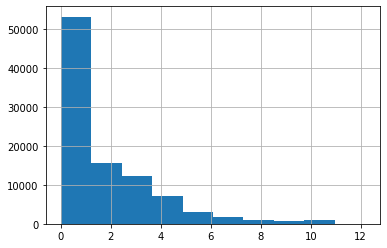

In [504]:
m_df['score_log'].hist()

<Axes: >

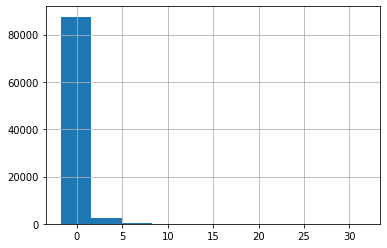

In [508]:
m_df['score_normalized'].hist()

In [511]:
top_sub = list(m_df.subreddit.value_counts().index)[:30]
m_df['subreddit_re'] = [it if it in top_sub else 'Other' for it in m_df.subreddit] 

In [745]:
'''
def coef_to_percent_change(coef):
    return (np.exp(coef) - 1) * 100

res_df = pd.DataFrame()
m_df['score_normalized'] = (m_df['score'] - m_df.groupby('subreddit')['score'].transform('mean')) / (m_df.groupby('subreddit')['score'].transform('std')+1)
m_df['score_log'] = np.log(m_df['score'] + 1)

#m_df['score_log'] = list(m_df['score'] / (m_df.groupby('subreddit')['score'].transform('mean')+1))

mm_df = m_df[(~m_df['score_normalized'].isna())]#.drop_duplicates(['title', 'doi'])
for idx, cat in enumerate(list(statements)[:]):
    mod = mixedlm(formula='score_log ~ subreddit_re +' + cat.replace(' ', '_'), data=mm_df, groups=mm_df['url'])
    res = mod.fit()
    
    t_df =  results_summary_to_dataframe(res)
    t_df['statement'] = cat
    
    t_df['coeff'] = t_df['coeff'].apply(coef_to_percent_change)
    
    res_df = pd.concat([res_df, t_df])
    print(res.summary())
'''

"\ndef coef_to_percent_change(coef):\n    return (np.exp(coef) - 1) * 100\n\nres_df = pd.DataFrame()\nm_df['score_normalized'] = (m_df['score'] - m_df.groupby('subreddit')['score'].transform('mean')) / (m_df.groupby('subreddit')['score'].transform('std')+1)\nm_df['score_log'] = np.log(m_df['score'] + 1)\n\n#m_df['score_log'] = list(m_df['score'] / (m_df.groupby('subreddit')['score'].transform('mean')+1))\n\nmm_df = m_df[(~m_df['score_normalized'].isna())]#.drop_duplicates(['title', 'doi'])\nfor idx, cat in enumerate(list(statements)[:]):\n    mod = mixedlm(formula='score_log ~ subreddit_re +' + cat.replace(' ', '_'), data=mm_df, groups=mm_df['url'])\n    res = mod.fit()\n    \n    t_df =  results_summary_to_dataframe(res)\n    t_df['statement'] = cat\n    \n    t_df['coeff'] = t_df['coeff'].apply(coef_to_percent_change)\n    \n    res_df = pd.concat([res_df, t_df])\n    print(res.summary())\n"

In [ ]:




pvalues_corrected = multipletests(res.pvalues, alpha=alpha_corrected, method='bonferroni')
res.pvalues = pvalues_corrected[1]

t_df =  results_summary_to_dataframe(res)
t_df['statement'] = key

# Merge VIF data with results dataframe
t_df = pd.merge(t_df, vif_data, left_on='index', right_on='Variable', how='left')
t_df.drop('Variable', axis=1, inplace=True)

In [776]:
statements

['Newsworthiness',
 'Expertise',
 'Fun',
 'Surprisingness',
 'Controversy',
 'Importance']

In [ ]:
'Newsworthiness',
 'Understandability',
 'Expertise',
 'Fun',
 'Importance',
 'Interestingness',
 'Sharing',
 'Benefit',
 'Surprisingness',
 'Controversy',
 'Exaggeration',
'Reading'

In [1021]:
statements = [#'Newsworthiness',
 #'Understandability',
 'Expertise',
 'Fun',
 'Importance',
 #'Interestingness',
 #'Sharing',
 #'Benefit',
 'Surprisingness',
 'Controversy',
 #'Exaggeration',
#'Reading'
]

In [ ]:
m_df['score_normalized'] = (m_df['score'] - m_df.groupby('subreddit')['score'].transform('mean')) / (m_df.groupby('subreddit')['score'].transform('std')+1)
m_df['score_log'] = np.log(m_df['score'] + 1)

In [980]:
top_domain = list(m_df.domain.value_counts().index)[:30]
m_df['domain_re'] = [it if it in top_domain else 'Other' for it in m_df.domain] 

In [989]:
m_df['domain_re'] = m_df['domain_re'].replace('youtu.be', 'youtube.com')

In [990]:
m_df_sorted = m_df.sort_values(by=['url', 'created_utc'])

# Use transform with rank to create the 'post_order' column
m_df_sorted['post_order'] = m_df_sorted.groupby(['subreddit', 'url'])['created_utc'].transform(lambda x: x.rank())
m_df_sorted['post_order_str'] = m_df_sorted['post_order'].apply(lambda x: str(int(x)) if x <= 1 else ">1")

In [987]:
m_df_sorted['post_order_str'].value_counts()

post_order_str
1     87842
>1     7623
Name: count, dtype: int64

In [1029]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def coef_to_percent_change(coef):
    return (np.exp(coef) - 1) * 100
    #return np.exp(coef)

res_df = pd.DataFrame()

#m_df['score_log'] = list(m_df['score'] / (m_df.groupby('subreddit')['score'].transform('mean')+1))

mm_df = m_df_sorted[(~m_df_sorted['score_normalized'].isna())&(m_df_sorted['subreddit_re']!='Other')]#.drop_duplicates(['title', 'doi'])

mod = mixedlm(formula='score_log ~ subreddit_re + domain_re + post_order_str + ' + '+'.join(statements), data=mm_df, groups=mm_df['url'])
res = mod.fit()

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = mod.exog_names
vif_data["VIF"] = [variance_inflation_factor(mod.exog, i) for i in range(mod.exog.shape[1])]

t_df =  results_summary_to_dataframe(res)
t_df['statement'] = cat

#t_df['coeff'] = t_df['coeff'].apply(coef_to_percent_change)
#t_df['SE'] = t_df['SE'] * t_df['coeff']

t_df = pd.merge(t_df, vif_data, left_on='index', right_on='Variable', how='left')
t_df.drop('Variable', axis=1, inplace=True)

res_df = t_df
print(res.summary())

                       Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         score_log   
No. Observations:           55031           Method:                     REML        
No. Groups:                 27888           Scale:                      3.6053      
Min. group size:            1               Log-Likelihood:             -117201.8109
Max. group size:            14              Converged:                  Yes         
Mean group size:            2.0                                                     
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                -0.899    0.067 -13.361 0.000 -1.030 -0.767
subreddit_re[T.DamnInteresting]           0.553    0.121   4.560 0.000  0.315  0.790
subr

In [1009]:
t_df

,index,p value,coeff,SE,conf_lower,conf_higher,term,statement,VIF
0,Intercept,1.024599e-40,-0.898588,0.067256,-1.030406,-0.766769,Intercept,Reading,60.524791
1,subreddit_re[T.DamnInteresting],5.122566e-06,0.552686,0.121211,0.315117,0.790255,subreddit_re[T.DamnInteresting],Reading,1.201416
2,subreddit_re[T.EcoInternet],7.392025e-01,0.022255,0.066849,-0.108767,0.153277,subreddit_re[T.EcoInternet],Reading,1.929983
3,subreddit_re[T.EverythingScience],2.796606e-60,1.056525,0.064513,0.930081,1.182968,subreddit_re[T.EverythingScience],Reading,2.241865
4,subreddit_re[T.Futurology],2.746058e-172,1.871944,0.066900,1.740823,2.003066,subreddit_re[T.Futurology],Reading,2.059756
...,...,...,...,...,...,...,...,...,...
61,Fun,8.525844e-09,0.196148,0.034067,0.129378,0.262918,Fun,Reading,3.307873
62,Importance,1.588954e-176,0.517238,0.018259,0.481451,0.553026,Importance,Reading,2.093349
63,Surprisingness,1.008777e-10,0.322972,0.049952,0.225068,0.420877,Surprisingness,Reading,4.578306
64,Controversy,6.547224e-01,-0.011154,0.024940,-0.060036,0.037729,Controversy,Reading,2.121256


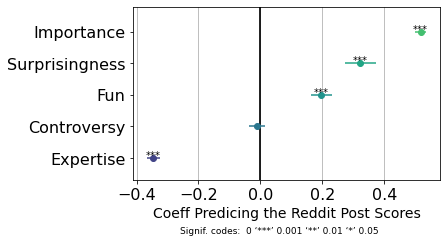

In [1030]:
t_df = res_df[res_df['index'].isin(statements)].sort_values('coeff')#[:-1]
t_df['index'] = t_df['statement']
#plot_reg_results(t_df, xlabel='Change of Reddit post scores when the \nestimated perceptions increase by one unit', figsize=(5, 3), filename='reg_reddit_post_score_unified')
plot_reg_results(t_df, xlabel='Coeff Predicing the Reddit Post Scores', figsize=(5, 3), filename='reg_reddit_post_score_unified')

In [1022]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def coef_to_percent_change(coef):
    #return (np.exp(coef) - 1) * 100
    return np.exp(coef)

res_df = pd.DataFrame()
m_df['score_normalized'] = (m_df['score'] - m_df.groupby('subreddit')['score'].transform('mean')) / (m_df.groupby('subreddit')['score'].transform('std')+1)
m_df['score_log'] = np.log(m_df['score'] + 1)

#m_df['score_log'] = list(m_df['score'] / (m_df.groupby('subreddit')['score'].transform('mean')+1))

mm_df = m_df_sorted[(~m_df_sorted['score_normalized'].isna())&(m_df_sorted['subreddit_re']!='Other')]#.drop_duplicates(['title', 'doi'])

mod = mixedlm(formula='num_comments_log ~ subreddit_re +  domain_re + post_order_str+ ' + '+'.join(statements), data=mm_df, groups=mm_df['url'])
res = mod.fit()

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["Variable"] = mod.exog_names
vif_data["VIF"] = [variance_inflation_factor(mod.exog, i) for i in range(mod.exog.shape[1])]

t_df =  results_summary_to_dataframe(res)
t_df['statement'] = cat

#t_df['coeff'] = t_df['coeff'].apply(coef_to_percent_change)
#t_df['SE'] = t_df['SE'] * t_df['coeff']

t_df = pd.merge(t_df, vif_data, left_on='index', right_on='Variable', how='left')
t_df.drop('Variable', axis=1, inplace=True)

res_df = t_df
print(res.summary())



                       Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        num_comments_log
No. Observations:         55031          Method:                    REML            
No. Groups:               27888          Scale:                     1.7571          
Min. group size:          1              Log-Likelihood:            -96958.1130     
Max. group size:          14             Converged:                 Yes             
Mean group size:          2.0                                                       
------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                -0.829    0.047 -17.794 0.000 -0.920 -0.737
subreddit_re[T.DamnInteresting]           0.053    0.084   0.636 0.525 -0.111  0.218
subr

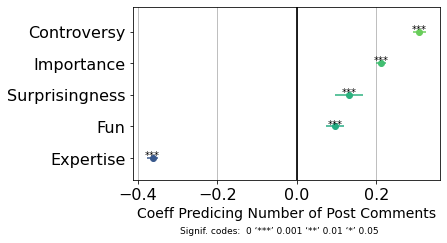

In [1028]:
t_df = res_df[res_df['index'].isin(statements)].sort_values('coeff')#[:-1]
t_df['index'] = t_df['statement']
#plot_reg_results(t_df, xlabel='Change of Reddit post comment amount when the \nestimated perceptions increase by one unit', figsize=(5, 3), filename='reg_reddit_post_comments_unified')
plot_reg_results(t_df, xlabel='Coeff Predicing Number of Post Comments', figsize=(5, 3), filename='reg_reddit_post_comments_unified')

In [704]:
res_df = pd.DataFrame()
m_df['score_normalized'] = (m_df['score'] - m_df.groupby('subreddit')['score'].transform('mean')) / (m_df.groupby('subreddit')['score'].transform('std')+1)
m_df['num_comments_log'] = np.log(m_df['num_comments'] + 1)

#m_df['score_log'] = list(m_df['score'] / (m_df.groupby('subreddit')['score'].transform('mean')+1))

mm_df = m_df[(~m_df['num_comments'].isna())]#.drop_duplicates(['title', 'doi'])
for idx, cat in enumerate(list(statements)[:]):
    mod = mixedlm(formula='num_comments_log ~ subreddit_re +' + cat.replace(' ', '_'), data=mm_df, groups=mm_df['url'])
    res = mod.fit()
    
    t_df =  results_summary_to_dataframe(res)
    t_df['statement'] = cat
    t_df['coeff'] = t_df['coeff'].apply(coef_to_percent_change)
    res_df = pd.concat([res_df, t_df])
    print(res.summary())

                    Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      num_comments_log
No. Observations:      95465        Method:                  REML            
No. Groups:            29099        Scale:                   1.4830          
Min. group size:       2            Log-Likelihood:          -159023.5887    
Max. group size:       19           Converged:               Yes             
Mean group size:       3.3                                                   
-----------------------------------------------------------------------------
                                  Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                         -0.763    0.033 -22.911 0.000 -0.829 -0.698
subreddit_re[T.DamnInteresting]   -0.013    0.075  -0.181 0.857 -0.160  0.133
subreddit_re[T.EcoInternet]        0.069    0.041   1.694 0.090 -0.011  0.148
subred

In [707]:
t_df

,index,p value,coeff,SE,conf_lower,conf_higher,term,statement
31,Expertise,1.277723e-31,-9.057828,0.008115,-0.110852,-0.079041,Expertise,Expertise
31,Importance,0.000000e+00,27.318342,0.006247,0.229276,0.253765,Importance,Importance
31,Understandability,0.000000e+00,30.349368,0.006477,0.252353,0.277743,Understandability,Understandability
31,Reading,0.000000e+00,34.202858,0.007803,0.278888,0.309476,Reading,Reading
31,Fun,1.792070e-234,34.235814,0.009005,0.276778,0.312077,Fun,Fun
31,Benefit,0.000000e+00,34.418167,0.007101,0.281867,0.309704,Benefit,Benefit
31,Exaggeration,1.621686e-156,36.442009,0.011658,0.287880,0.333579,Exaggeration,Exaggeration
31,Surprisingness,1.101694e-186,38.813218,0.011254,0.305901,0.350017,Surprisingness,Surprisingness
31,Interestingness,0.000000e+00,40.525376,0.006901,0.326692,0.353744,Interestingness,Interestingness
31,Sharing,0.000000e+00,41.796643,0.008327,0.332904,0.365543,Sharing,Sharing


<ipython-input-636-ea93abb686c6>:111: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=14)


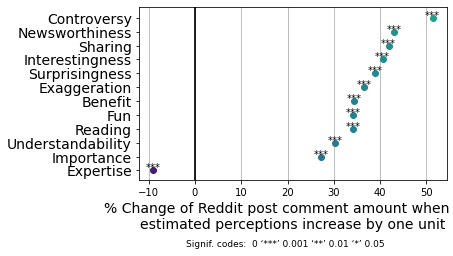

In [706]:
t_df = res_df[res_df['index'].isin(statements)].sort_values('coeff')#[:-1]
t_df['index'] = t_df['statement']
plot_reg_results(t_df, xlabel='% Change of Reddit post comment amount when the \nestimated perceptions increase by one unit', figsize=(5, 3), filename='reg_reddit_post_comments')

<ipython-input-366-7e380e0b4632>:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=14)


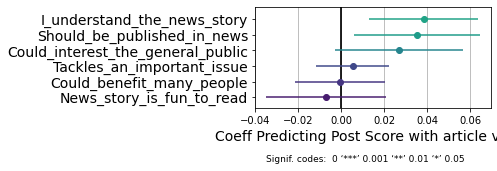

In [371]:
t_df = res_df[~res_df['index'].isin(['Intercept', 'Group Var'])].sort_values('coeff')#[:-1]
t_df['index'] = t_df['statement']
plot_reg_results(t_df, xlabel='Coeff Predicting Post Score with article value')

In [528]:
top_subreddits = list(m_df.subreddit.value_counts()[:20].index)

In [268]:
len(set(a_df.url) & set(m_df.url))

135

In [1]:
1

1

<ipython-input-232-b3bf510b4f04>:21: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), hue = 'subreddit_type', join=False)


<Axes: xlabel='corr', ylabel='statement'>

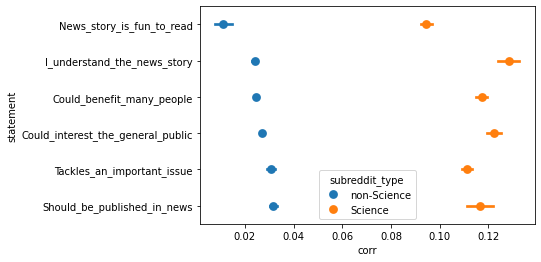

In [232]:
t_df = defaultdict(list)
for s in list(sel_statements.keys())[:-2]:
    s = s.replace(' ','_')
    #print(s, df['score_p'].corr(df['sci_%s'%s]), df['score_p'].corr(df['nonsci_%s'%s]))
    for k in ['Science', 'non-Science']:
        a_df = m_df[m_df['subreddit_type']==k]

        t_df['statement'].append(s)
        #t_df['statement'].append(sel_statements[s.replace('_',' ')])

        t_df['corr'].append(a_df['score_p'].corr(a_df['sci_%s'%s]))
        t_df['subreddit_type'].append(k)
        t_df['prediction_type'].append('sci')

        t_df['statement'].append(s)
        t_df['corr'].append(a_df['score_p'].corr(a_df['nonsci_%s'%s]))
        t_df['subreddit_type'].append(k)
        t_df['prediction_type'].append('nonsci')

t_df = pd.DataFrame(t_df)
sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), hue = 'subreddit_type', join=False)

<Axes: xlabel='subreddit_type', ylabel='corr'>

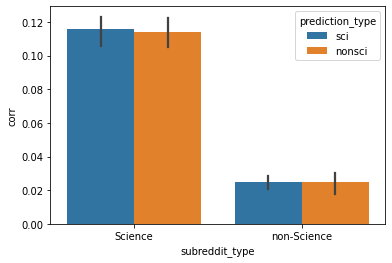

In [234]:
sns.barplot(x='subreddit_type', y='corr', hue='prediction_type', data=t_df)

<ipython-input-235-f75e22c0dede>:17: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), hue = 'subreddit_type', join=False)


<Axes: xlabel='corr', ylabel='statement'>

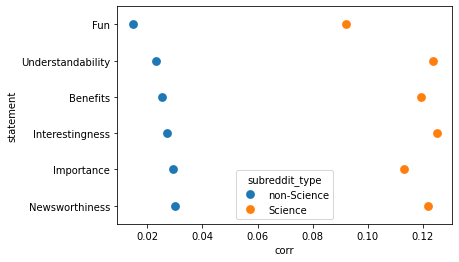

In [235]:
t_df = defaultdict(list)
for s in list(sel_statements.values())[:-2]:
    s = s.replace(' ','_')
    #print(s, df['score_p'].corr(df['sci_%s'%s]), df['score_p'].corr(df['nonsci_%s'%s]))
    for k in ['Science', 'non-Science']:
        a_df = m_df[m_df['subreddit_type']==k]

        t_df['statement'].append(s)
        #t_df['statement'].append(sel_statements[s.replace('_',' ')])

        t_df['corr'].append(a_df['score_p'].corr(a_df['%s'%s]))
        t_df['subreddit_type'].append(k)
        t_df['prediction_type'].append('all')


t_df = pd.DataFrame(t_df)
sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), hue = 'subreddit_type', join=False)

<ipython-input-220-6fe8f2124d55>:17: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), hue = 'subreddit_type', join=True)


<Axes: xlabel='corr', ylabel='statement'>

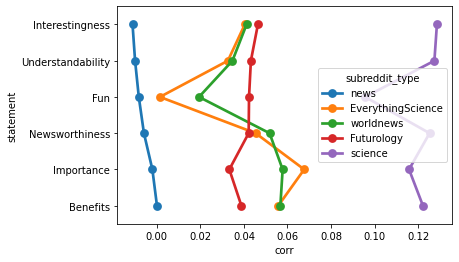

In [220]:
t_df = defaultdict(list)
for s in list(sel_statements.values())[:-2]:
    s = s.replace(' ','_')
    #print(s, df['score_p'].corr(df['sci_%s'%s]), df['score_p'].corr(df['nonsci_%s'%s]))
    for k in top_subreddits[:5]:
        a_df = m_df[m_df['subreddit_p']==k]

        t_df['statement'].append(s)
        #t_df['statement'].append(sel_statements[s.replace('_',' ')])

        t_df['corr'].append(a_df['score_p'].corr(a_df['%s'%s]))
        t_df['subreddit_type'].append(k)
        t_df['prediction_type'].append('all')


t_df = pd.DataFrame(t_df)
sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), hue = 'subreddit_type', join=True)

In [221]:
m_df[m_df['subreddit_type']=='non-Science'][['title_p', 'title_c']]

,title_p,title_c
1,Graphene Oxide use to create artificial photos...,Graphene Oxide use to create artificial photos...
2,It's official. Humans are going to Mars. NASA ...,Humans Are Going to Mars. NASA Has Unveiled Th...
3,It’s Official. Humans Are Going to Mars.,Humans Are Going to Mars. NASA Has Unveiled Th...
5,"I FOR ONE AM SATISFIED THAT OUR BROTHERS, I ME...",Humans Are Going to Mars. NASA Has Unveiled Th...
6,It's Official. Humans Are Going to Mars. NASA ...,Humans Are Going to Mars. NASA Has Unveiled Th...
...,...,...
661467,Physics theory used to predict crowd behavior ...,Physics theory used to predict crowd behavior ...
661468,Physics theory used to predict crowd behavior ...,Physics theory used to predict crowd behavior ...
661469,Physics theory used to predict crowd behavior ...,Physics theory used to predict crowd behavior ...
661511,Default mode network abnormalities in posttrau...,Default mode network abnormalities in posttrau...


In [222]:
m_df['subreddit_type'].value_counts()

subreddit_type
non-Science    210132
Science        105897
Name: count, dtype: int64

<Axes: xlabel='score_p', ylabel='subreddit_type'>

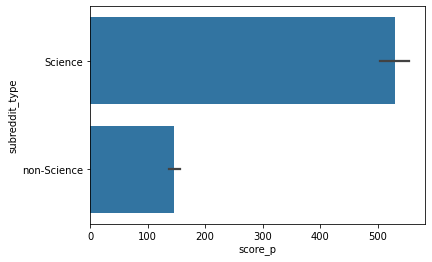

In [223]:
sns.barplot(x='score_p', y='subreddit_type', data=m_df)

In [253]:
m_df['score_p_normalized'] = m_df['score_p'] / m_df.groupby('subreddit_p')['score_p'].transform('mean')

KeyError: 'Importance_cat'

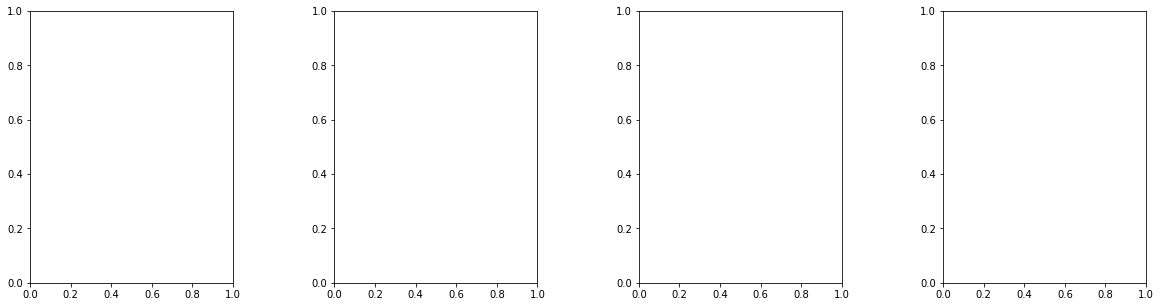

In [478]:
bad_urls = ['http://google.com']
fig, axs = plt.subplots(1, len(sel_statements)-2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots
for idx, cat in enumerate(list(sel_statements.values())[:-2]):
    ax = sns.pointplot(x=cat + '_cat', y='score_p', data=m_df[(m_df['subreddit'].isin(top_subreddits))&(m_df[cat + '_cat'] < 4)&(m_df['subreddit_type']=='non-Science')], ax=axs[idx])
    ax.set_ylabel('Post score')
    ax.set_xlabel(f'Post {cat.lower()}')
    ax.set_title(f'{cat}')

KeyError: 'Importance_cat'

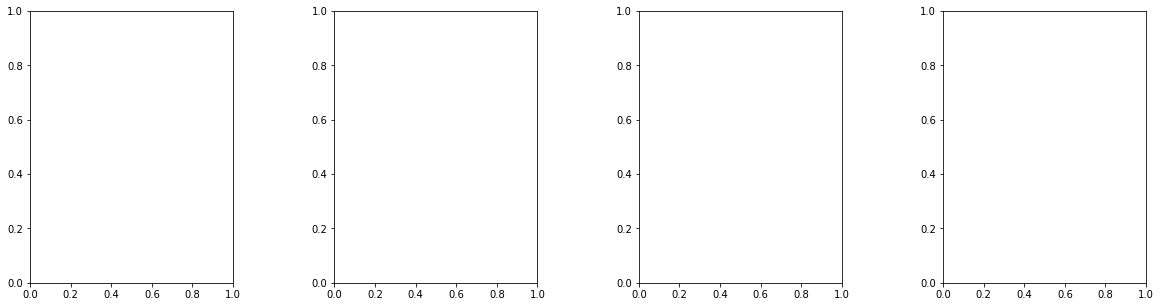

In [527]:
bad_urls = ['http://google.com']
fig, axs = plt.subplots(1, len(sel_statements)-2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots
for idx, cat in enumerate(list(sel_statements.values())[:-2]):
    ax = sns.pointplot(x=cat + '_cat', y='score_log', data=m_df[(m_df['subreddit'].isin(top_subreddits))&(m_df[cat + '_cat'] < 4)&(m_df['subreddit_type']=='non-Science')], ax=axs[idx])
    ax.set_ylabel('Post score')
    ax.set_xlabel(f'Post {cat.lower()}')
    ax.set_title(f'{cat}')

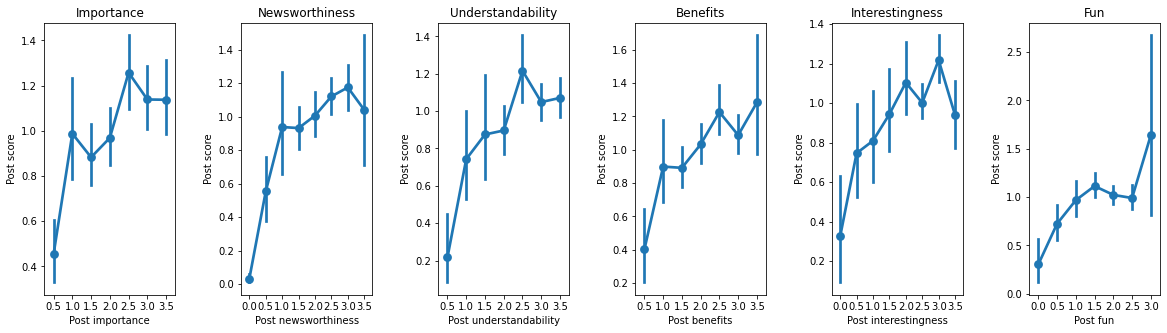

In [260]:
bad_urls = ['http://google.com']
fig, axs = plt.subplots(1, len(sel_statements)-2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots
for idx, cat in enumerate(list(sel_statements.values())[:-2]):
    ax = sns.pointplot(x=cat + '_cat', y='score_p_normalized', data=m_df[(m_df['subreddit_p'].isin(top_subreddits))&(m_df[cat + '_cat'] < 4)&(m_df['subreddit_type']=='non-Science')], ax=axs[idx])
    ax.set_ylabel('Post score')
    ax.set_xlabel(f'Post {cat.lower()}')
    ax.set_title(f'{cat}')

In [249]:
m_df[(~m_df['url'].isin(bad_urls))&(m_df['Understandability' + '_cat'] == 3)&(m_df['subreddit_type']=='non-Science')]['score_p'].mean()

251.10268510313847

In [257]:
m_df[(~m_df['url'].isin(bad_urls))&(m_df['Importance' + '_cat'] ==4)&(m_df['subreddit_type']=='non-Science')]

,author_p,created_utc_p,domain_p,id_p,num_comments_p,score_p,url,over_18_p,permalink_p,selftext_p,...,Sharing__cat,Importance_cat,Newsworthiness_cat,Understandability_cat,Benefits_cat,Interestingness_cat,Fun_cat,year,subreddit_type,score_p_normalized
110952,Wagamaga,1552732863,airqualitynews.com,b1r5hx,0,4,https://airqualitynews.com/2019/03/14/reducing...,False,/r/Futurology/comments/b1r5hx/reducing_emissio...,,...,1.5,4.0,3.0,3.0,3.0,3.0,1.0,2019,non-Science,0.005302
110953,Wagamaga,1552732876,airqualitynews.com,b1r5k7,0,6,https://airqualitynews.com/2019/03/14/reducing...,False,/r/environment/comments/b1r5k7/reducing_emissi...,,...,1.5,4.0,3.0,3.0,3.0,3.0,1.0,2019,non-Science,0.072234
437716,Wagamaga,1541100406,spring.org.uk,9tclkb,11,54,https://www.spring.org.uk/2018/11/3-types-of-d...,False,/r/psychology/comments/9tclkb/three_subtypes_o...,,...,1.5,4.0,3.0,3.0,3.5,3.0,1.5,2018,non-Science,0.309318
437717,Wagamaga,1541100430,spring.org.uk,9tclog,0,7,https://www.spring.org.uk/2018/11/3-types-of-d...,False,/r/sciences/comments/9tclog/three_subtypes_of_...,,...,1.5,4.0,3.0,3.0,3.5,3.0,1.5,2018,non-Science,0.275397
437718,Theoneisis,1541118255,spring.org.uk,9tf65f,65,243,https://www.spring.org.uk/2018/11/3-types-of-d...,False,/r/Nootropics/comments/9tf65f/three_subtypes_o...,,...,1.5,4.0,3.0,3.0,3.5,3.0,1.5,2018,non-Science,2.978695
437719,itmjack,1541133268,spring.org.uk,9th075,0,1,https://www.spring.org.uk/2018/11/3-types-of-d...,False,/r/CitizenPsychiatry/comments/9th075/3_types_o...,,...,1.5,4.0,3.0,3.0,3.5,3.0,1.5,2018,non-Science,0.650000
649770,worldnewsbot,1533049602,sciencealert.com,93f98o,0,2,https://www.sciencealert.com/depression-linked...,False,/r/theworldnews/comments/93f98o/people_who_liv...,,...,1.5,4.0,3.0,3.0,3.5,3.0,1.5,2018,non-Science,0.557974
649771,[deleted],1533898754,sciencealert.com,965xs3,1,1,https://www.sciencealert.com/depression-linked...,False,/r/todayilearned/comments/965xs3/tll_a_lack_of...,[deleted],...,1.5,4.0,3.0,3.0,3.5,3.0,1.5,2018,non-Science,0.001425


In [262]:
m_df

,author_p,created_utc_p,domain_p,id_p,num_comments_p,score_p,url,over_18_p,permalink_p,selftext_p,...,Sharing__cat,Importance_cat,Newsworthiness_cat,Understandability_cat,Benefits_cat,Interestingness_cat,Fun_cat,year,subreddit_type,score_p_normalized
0,SuccessHook,1493596801,graphene-uses.com,68irh1,4,52,http://www.graphene-uses.com/graphene-oxide-us...,False,/r/science/comments/68irh1/graphene_oxide_use_...,,...,1.5,2.0,2.0,2.0,1.5,1.5,1.5,2017,Science,0.093561
1,SuccessHook,1501593583,graphene-uses.com,6qw5uz,0,9,http://www.graphene-uses.com/graphene-oxide-us...,False,/r/environment/comments/6qw5uz/graphene_oxide_...,,...,1.5,2.0,2.0,2.0,1.5,1.5,1.5,2017,non-Science,0.108351
2,icorrectotherpeople,1493597011,futurism.com,68is68,2312,38309,https://futurism.com/its-official-humans-are-g...,False,/r/technology/comments/68is68/its_official_hum...,,...,1.5,1.5,2.5,3.0,2.0,2.5,2.0,2017,non-Science,124.647200
3,fredphreak,1493615677,futurism.com,68k784,0,2,https://futurism.com/its-official-humans-are-g...,False,/r/CurrentGeek/comments/68k784/its_official_hu...,,...,1.5,1.5,2.5,3.0,2.0,2.5,2.0,2017,non-Science,0.309333
4,crackminds,1493616842,futurism.com,68k9nn,0,1,https://futurism.com/its-official-humans-are-g...,False,/r/science/comments/68k9nn/humans_are_going_to...,,...,1.5,1.5,2.5,3.0,2.0,2.5,2.0,2017,Science,0.001799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661517,MAD_OR_NAW,1535746854,youtube.com,9bx231,1,1,https://www.youtube.com/attribution_link?a=gf_...,False,/r/science/comments/9bx231/can_dehydration_aff...,,...,1.5,2.0,2.0,3.0,2.0,2.5,2.0,2018,Science,0.001799
661518,yourpooch,1535746859,ai.googleblog.com,9bx23i,0,1,https://ai.googleblog.com/2018/08/understandin...,False,/r/science/comments/9bx23i/understanding_perfo...,,...,1.0,1.5,1.0,1.0,1.0,0.5,0.5,2018,Science,0.001799
661519,[deleted],1535751827,kusi.com,9bxpw0,5,5,https://www.kusi.com/week-3-hog-blog-back-to-t...,False,/r/science/comments/9bxpw0/little_did_doc_brow...,[deleted],...,1.5,2.0,2.5,3.5,2.0,2.5,2.0,2018,Science,0.008996
661520,SativaLungz,1535751855,robertlanzabiocentrism.com,9bxpzw,6,1,http://www.robertlanzabiocentrism.com/is-death...,False,/r/Psychonaut/comments/9bxpzw/is_death_an_illu...,,...,1.5,1.5,1.5,2.0,1.0,2.0,1.5,2015,non-Science,0.008026


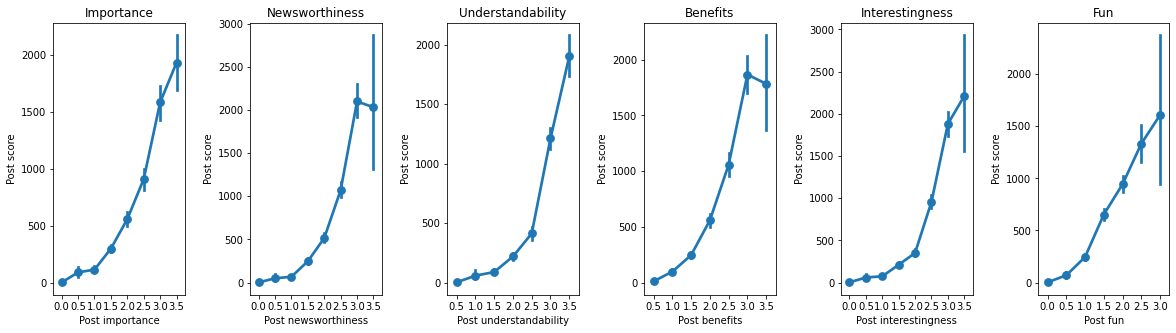

In [231]:
fig, axs = plt.subplots(1, len(sel_statements)-2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots
for idx, cat in enumerate(list(sel_statements.values())[:-2]):
    ax = sns.pointplot(x=cat + '_cat', y='score_p', data=m_df[(m_df[cat + '_cat'] < 4)&(m_df['subreddit_type']=='Science')], ax=axs[idx])
    ax.set_ylabel('Post score')
    ax.set_xlabel(f'Post {cat.lower()}')
    ax.set_title(f'{cat}')

In [194]:
from datetime import datetime

def get_year_from_unix_timestamp(unix_timestamp):
    try:
        # Convert the Unix timestamp to a datetime object
        utc_datetime = datetime.utcfromtimestamp(int(unix_timestamp))
        # Extract the year from the datetime object
        year = utc_datetime.year
        return year
    except ValueError:
        print("Error: Invalid Unix timestamp.")
        return None
    
df['year'] = [get_year_from_unix_timestamp(it) for it in df['created_utc']]

In [195]:
df.year.value_counts()

year
2014    68771
2015    61776
2016    58382
2017    51033
2018    40688
2019    14224
Name: count, dtype: int64

In [193]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'retrieved_on', 'selftext', 'media',
       'link_flair_text', 'permalink', 'title', 'secure_media_embed',
       'thumbnail',
       ...
       'Interestingness__cat', 'Fun__cat', 'Surprising__cat', 'Sharing__cat',
       'Importance_cat', 'Newsworthiness_cat', 'Understandability_cat',
       'Benefits_cat', 'Interestingness_cat', 'Fun_cat'],
      dtype='object', length=130)

In [150]:
df['title']

0         In California Drought, Desperation May Make Wa...
1         Top male science professors (Nobel Laureates, ...
2         Study suggests mega-population boom among sout...
3         Controversial theory suggests the speed of lig...
4                    Russia launching powerful laser system
                                ...                        
294869    Extraterrestrial organic matter preserved in 3...
294870                  Next Einstein of our generation (?)
294871    Extraterrestrial organic matter preserved in 3...
294872    Iranian girl scores higher than Einstein on Me...
294873    Research shows for the first time that a small...
Name: title, Length: 294874, dtype: object

In [ ]:
fig, axs = plt.subplots(1, len(sel_statements)-2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots
for idx, cat in enumerate(list(sel_statements.values())[:-2]):
    ax = sns.pointplot(x=cat + '_cat', y='score_p', data=m_df[(m_df[cat + '_cat'] < 4)&(m_df['subreddit_type']=='non-Science')], ax=axs[idx])
    ax.set_ylabel('Post score')
    ax.set_xlabel(f'Post {cat.lower()}')
    ax.set_title(f'{cat}')

In [36]:
topic_df = pd.read_csv('../../match-finding/data/reddit_science_300k_with_topic.csv')

<ipython-input-36-cc062087aec9>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  topic_df = pd.read_csv('../../match-finding/data/reddit_science_300k_with_topic.csv')


In [40]:
df['topic'] = ['other' if len(eval(it)) == 0 else eval(it)[0] for it in topic_df['pred_labels']]
df['topic'].value_counts()

topic
other             95942
Humanities        54261
Engineering       54091
Medical           35613
Biology           24955
Physics           12178
Chemistry         10707
Social Science     7127
Name: count, dtype: int64

In [105]:
df.to_csv('../data/reddit_df.csv')

In [109]:
df['domain'].value_counts()[:40]

domain
youtube.com                18900
nature.com                  6832
sciencedaily.com            6532
phys.org                    5315
youtu.be                    4392
eurekalert.org              3657
theguardian.com             2862
bbc.com                     2741
bioengineer.org             2624
pinterest.com               2498
imgur.com                   2363
nytimes.com                 2317
ncbi.nlm.nih.gov            1833
sciencedirect.com           1833
washingtonpost.com          1750
scientificamerican.com      1697
newscientist.com            1670
sciencemag.org              1578
iflscience.com              1575
livescience.com             1562
psypost.org                 1436
self.science                1408
onlinelibrary.wiley.com     1376
sciencealert.com            1373
pnas.org                    1332
sciencenews.org             1289
i.imgur.com                 1273
journals.plos.org           1184
bbc.co.uk                   1161
arstechnica.com             1138
mig

In [4]:
def extract_domain(url):
    parsed_url = urlparse(url)
    if parsed_url.netloc.startswith('www.'):
        return parsed_url.netloc[4:]
    else:
        return parsed_url.netloc

def get_domain_cat(d):
    if d.split('.')[-1] == 'edu':
        return 'PressRelease'
    elif d in ['sciencedaily.com', 'nature.com', 'eurekalert.org']:
        return 'PressRelease'
    elif d in ['phys.org']:
        return 'SciTech'
    elif d in domain2cat:
        return domain2cat[d]
    else:
        return None
#unique_df = pd.read_csv('../data/unique_df_with_scores.csv')

In [23]:
unique_df['domain'] = [extract_domain(url) for url in unique_df['url']]
unique_df = unique_df[['domain', 'category']].drop_duplicates()
domain2cat = {k:v for k,v in zip(unique_df['domain'], unique_df['category'])}

In [36]:
domain2cat['phys.org']

'General'

In [66]:
df = pd.read_csv('../data/reddit_df_full.csv')

<ipython-input-66-9a741d77aa74>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/reddit_df_full.csv')


In [24]:
ddf = df['domain'].value_counts().reset_index()

In [34]:
ddf[~ddf['domain'].isin(domain2cat)].reset_index().to_csv('../data/reddit_domains.csv')

In [41]:
r_domain = pd.read_csv('../data/Domain classification - Sheet1.csv')
for k,v in zip(r_domain.domain, r_domain.category):
    if str(v) != 'nan':
        domain2cat[k] = v

In [5]:
df['category'] = [get_domain_cat(str(d)) for d in df.domain]

NameError: name 'domain2cat' is not defined

In [71]:
top_domain = list(df[['domain', 'category']].value_counts().reset_index()['domain'][:30])

In [72]:
top_domain

['youtube.com',
 'nature.com',
 'sciencedaily.com',
 'phys.org',
 'youtu.be',
 'eurekalert.org',
 'theguardian.com',
 'bbc.com',
 'bioengineer.org',
 'pinterest.com',
 'imgur.com',
 'nytimes.com',
 'sciencedirect.com',
 'ncbi.nlm.nih.gov',
 'washingtonpost.com',
 'scientificamerican.com',
 'newscientist.com',
 'sciencemag.org',
 'iflscience.com',
 'livescience.com',
 'psypost.org',
 'onlinelibrary.wiley.com',
 'sciencealert.com',
 'pnas.org',
 'sciencenews.org',
 'i.imgur.com',
 'journals.plos.org',
 'bbc.co.uk',
 'arstechnica.com',
 'reddit.com']

<Axes: xlabel='num_comments', ylabel='domain'>

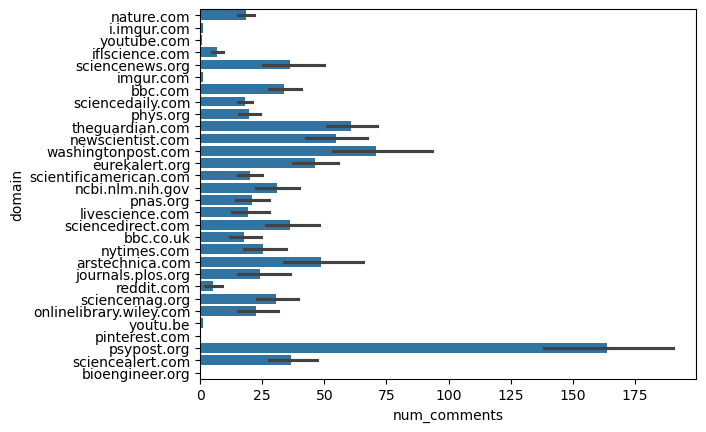

In [82]:
sns.barplot(y='domain', x='num_comments', data=df[df['domain'].isin(top_domain)])

In [95]:
df.score.value_counts()

score
1       153387
0        27391
2        13203
3         8476
4         5960
         ...  
5798         1
6054         1
5967         1
4168         1
3541         1
Name: count, Length: 6355, dtype: int64

In [113]:
df.columns

Index(['Unnamed: 0', 'retrieved_on', 'selftext', 'media', 'link_flair_text',
       'permalink', 'title', 'secure_media_embed', 'thumbnail',
       'distinguished', 'domain', 'created_utc', 'author_flair_text',
       'media_embed', 'subreddit', 'edited', 'score', 'stickied',
       'secure_media', 'url', 'subreddit_id', 'is_self', 'author',
       'link_flair_css_class', 'gilded', 'id', 'archived',
       'author_flair_css_class', 'num_comments', 'over_18',
       'author_flair_richtext', 'sci_My_social_media_feed',
       'sci_General_public', 'sci_News_story_is_interesting_to_me',
       'sci_Tackles_an_important_issue',
       'sci_Shouldnt_be_public_outside_science',
       'sci_Would_share_on_wider_forum', 'sci_News_story_is_fun_to_read',
       'sci_Finding_is_surprising_to_me', 'sci_Sci_Tech_media',
       'sci_Other_popular_media', 'sci_Policy_makers',
       'sci_Should_be_published_in_news', 'sci_Could_benefit_many_people',
       'sci_Related_industry_companies', 'sci_Findi

In [6]:
def num2cat(num):
    if num == 0:
        return '0'
    elif num == 1:
        return '1'
    elif num <= 5:
        return '2-5'
    elif num <= 10:
        return '6-10'
    elif num <= 20:
        return '11-20'
    elif num <= 30:
        return '21-30'
    elif num <= 50:
        return '31-50'
    elif num <= 100:
        return '51-100'
    else:
        return '100+'

df['num_comments_binary'] = df['num_comments'].astype(bool).astype(int)
df['score_cat'] = [num2cat(it) for it in df['score']]

In [73]:
sel_statements

{'all_Tackles an important issue': 'Importance_',
 'all_Should be published in news': 'Newsworthiness_',
 'all_I understand the news story': 'Understandability_',
 'all_Could benefit many people': 'Benefits_',
 'all_Could interest the general public': 'Interestingness_',
 'all_News story is fun to read': 'Fun_',
 'all_Finding is surprising to me': 'Surprising_',
 'all_Would share on wider forum': 'Sharing_'}

In [74]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'retrieved_on', 'selftext', 'media',
       'link_flair_text', 'permalink', 'title', 'secure_media_embed',
       'thumbnail',
       ...
       'all_I_understand_the_news_story', 'all_Needs_specialized_knowledge',
       'all_Unlikely_to_share', 'all_Could_interest_the_general_public',
       'all_I_learned_something_useful', 'all_A_public_segment',
       'all_News_story_is_exaggerated', 'all_Popular_print_media',
       'all_Would_share_directly', 'all_General_news_outlets'],
      dtype='object', length=116)

In [76]:
sel_statements = {'all_'+it.replace(' ', '_'):sel_statements[it] + '_' for it in sel_statements}

In [77]:
df = df.rename(columns=sel_statements)

In [532]:
df = m_df

In [711]:
for s in list(statements):
    print(s)
    df[s + '_cat'] = [int(it * 1) / 1 for it in df[s]]


Newsworthiness
Understandability
Expertise
Fun
Importance
Interestingness
Sharing
Benefit
Surprisingness
Controversy
Exaggeration
Reading


In [731]:
df['Controversy_cat'].value_counts()

Controversy_cat
1.0    66063
0.0    15030
2.0    14102
3.0      270
Name: count, dtype: int64

In [954]:
df

,author,created_utc,domain,id,num_comments,score,url,over_18,permalink,selftext,...,Sharing_cat,Benefit_cat,Surprisingness_cat,Controversy_cat,Exaggeration_cat,Expertise,Expertise_cat,Reading,Reading_cat,num_comments_log
6,BrapAllgood,1493600281,arstechnica.com,68j20b,0,1,https://arstechnica.com/science/2017/04/no-bon...,False,/r/C_D_T/comments/68j20b/no_bones_needed_ancie...,,...,1.0,2.0,2.0,1.0,1.0,1.280657,1.0,2.572918,2.0,0.000000
14,CopyCenterPhil,1493602835,wired.com,68j9nm,0,11,https://www.wired.com/2017/01/paperfuge-20-cen...,False,/r/technology/comments/68j9nm/the_paperfuge_a_...,,...,1.0,1.0,1.0,0.0,0.0,1.347209,1.0,1.461631,1.0,0.000000
16,Foof1ght3r,1493603534,bbc.com,68jbnr,3,0,http://www.bbc.com/news/science-environment-39...,False,/r/europe/comments/68jbnr/evidence_of_ancient_...,,...,0.0,0.0,1.0,0.0,0.0,0.877382,0.0,1.221719,1.0,1.386294
17,SteRoPo,1493603907,sahlgrenska.gu.se,68jcq7,0,48,http://sahlgrenska.gu.se/english/research/news...,False,/r/science/comments/68jcq7/researchers_generat...,,...,1.0,2.0,2.0,1.0,1.0,2.290599,2.0,2.339353,2.0,0.000000
19,Sampo,1493604121,sciencemag.org,68jdcy,6,82,http://www.sciencemag.org/news/2017/04/paper-a...,False,/r/science/comments/68jdcy/paper_about_how_mic...,,...,2.0,3.0,1.0,1.0,0.0,1.462802,1.0,2.754750,2.0,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13258,FillsYourNiche,1535754788,news.mongabay.com,9by3bi,0,88,https://news.mongabay.com/2018/08/cheap-prices...,False,/r/ScienceFacts/comments/9by3bi/cheap_prices_l...,,...,2.0,2.0,1.0,1.0,1.0,0.523971,0.0,2.752882,2.0,0.000000
13259,[deleted],1535755523,sanger.ac.uk,9by6gc,0,1,https://www.sanger.ac.uk/news/view/newly-seque...,False,/r/news/comments/9by6gc/golden_eagle_genome_st...,[deleted],...,2.0,2.0,1.0,1.0,0.0,1.526676,1.0,2.462149,2.0,0.000000
13262,HearTomorrow,1535756965,wyss.harvard.edu,9bycrh,0,4,https://wyss.harvard.edu/a-telephone-for-your-...,False,/r/ScienceUncensored/comments/9bycrh/a_telepho...,,...,2.0,2.0,2.0,1.0,1.0,1.871331,1.0,2.584116,2.0,0.000000
13264,eigenvalueprince,1535757629,news.cornell.edu,9byfkh,0,1,http://news.cornell.edu/stories/2018/08/physic...,False,/r/u_eigenvalueprince/comments/9byfkh/physics_...,,...,1.0,1.0,1.0,0.0,1.0,1.353115,1.0,1.709353,1.0,0.000000


In [999]:
len(m_df)

95465

In [998]:
len(df)

95465

<ipython-input-972-1c7b2d7a607c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['style'] = cat
<ipython-input-972-1c7b2d7a607c>:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.pointplot(x=cat + '_cat', y='score', data=t_df, errwidth=2, capsize=0.2, linewidth=0.5, ax=ax)
<ipython-input-972-1c7b2d7a607c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['style'] = cat
<ipython-input-972-1c7b2d7a607c>:14: 

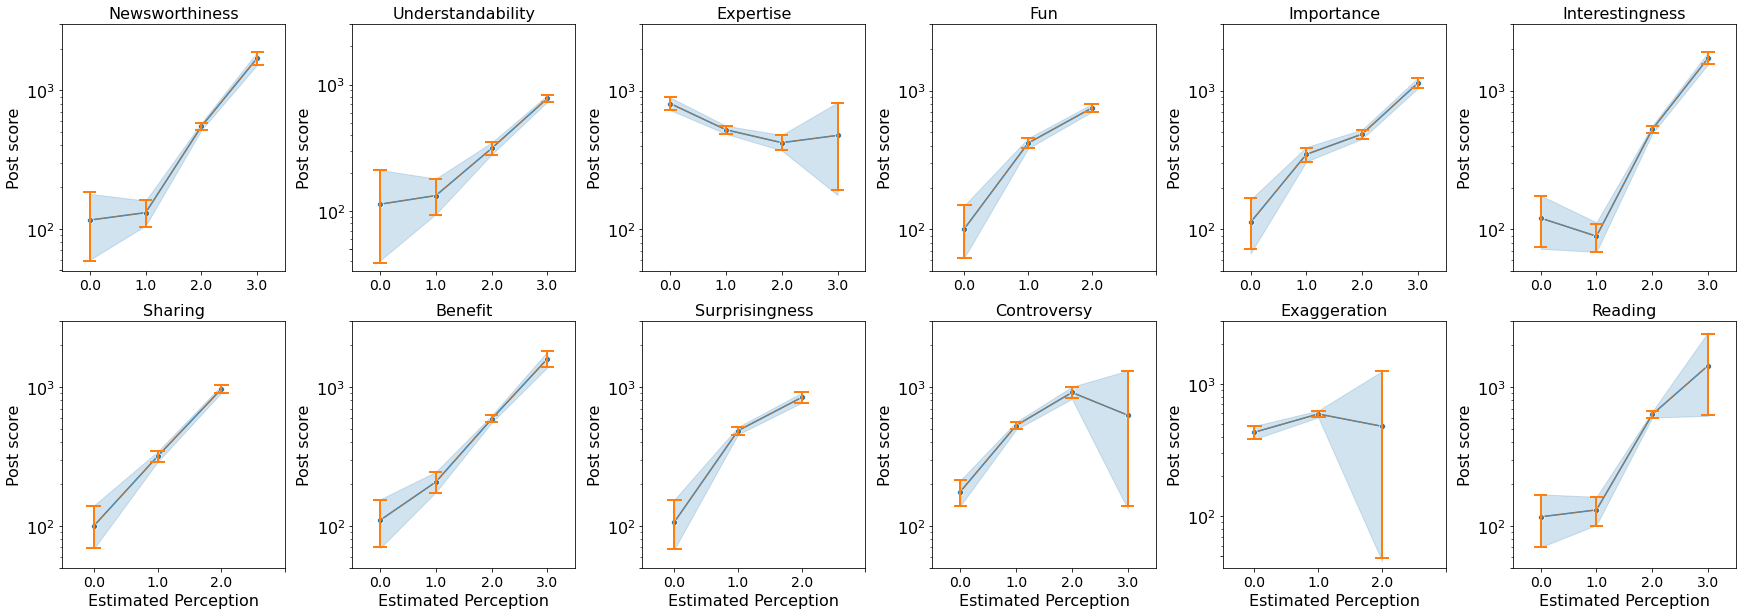

In [972]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 6, figsize=(30, 10))  # Create a 2x6 plot grid
plt.subplots_adjust(wspace=0.3, hspace=0.2)  # Adjust the horizontal and vertical space between subplots

# Assuming statements is a list of length 12
for idx, cat in enumerate(list(statements)[:12]):
    t_df = df[(df[cat + '_cat'] < 5) & (df['len'] > 7) & (df['Surprisingness_cat'] != 3.0) & (df['Fun_cat'] != 3.0)]
    t_df['style'] = cat
    row = idx // 6  # Calculate the row index
    col = idx % 6  # Calculate the column index
    ax = sns.lineplot(x=cat + '_cat', y='score', data=t_df, ax=axs[row, col], style="style", markers=True, dashes=True)
    sns.pointplot(x=cat + '_cat', y='score', data=t_df, errwidth=2, capsize=0.2, linewidth=0.5, ax=ax)
    ax.set_ylabel('Post score', fontsize=16)
    ax.set_title(cat, fontsize=16)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yscale('log')  # Set the y-axis scale to log scale
    ax.get_legend().remove()

    if row == 1:  # Check if it's the bottom row
        ax.set_xlabel('Estimated Perception', fontsize=16)  # Set x-axis label for the bottom row only
    else:
        ax.set_xlabel('', fontsize=16)

    ax.tick_params(axis='x', labelsize=14)  # Size of x-axis tick labels
    ax.tick_params(axis='y', labelsize=16)  # Size of y-axis tick labels

    # Add more y-axis tick labels
    yticklabels = [50, 100, 1000, 3000]  # Customize these as needed
    ax.set_yticks(yticklabels)

plt.savefig('../shared_data/figures/reddit_score_perception_pointplot.pdf', bbox_inches='tight')

<ipython-input-974-2ca2afef61d2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['style'] = cat
<ipython-input-974-2ca2afef61d2>:14: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  sns.pointplot(x=cat + '_cat', y='num_comments', data=t_df, errwidth=2, capsize=0.2, linewidth=0.5, ax=ax)
<ipython-input-974-2ca2afef61d2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['style'] = cat
<ipython-input-974-2ca2afef61d

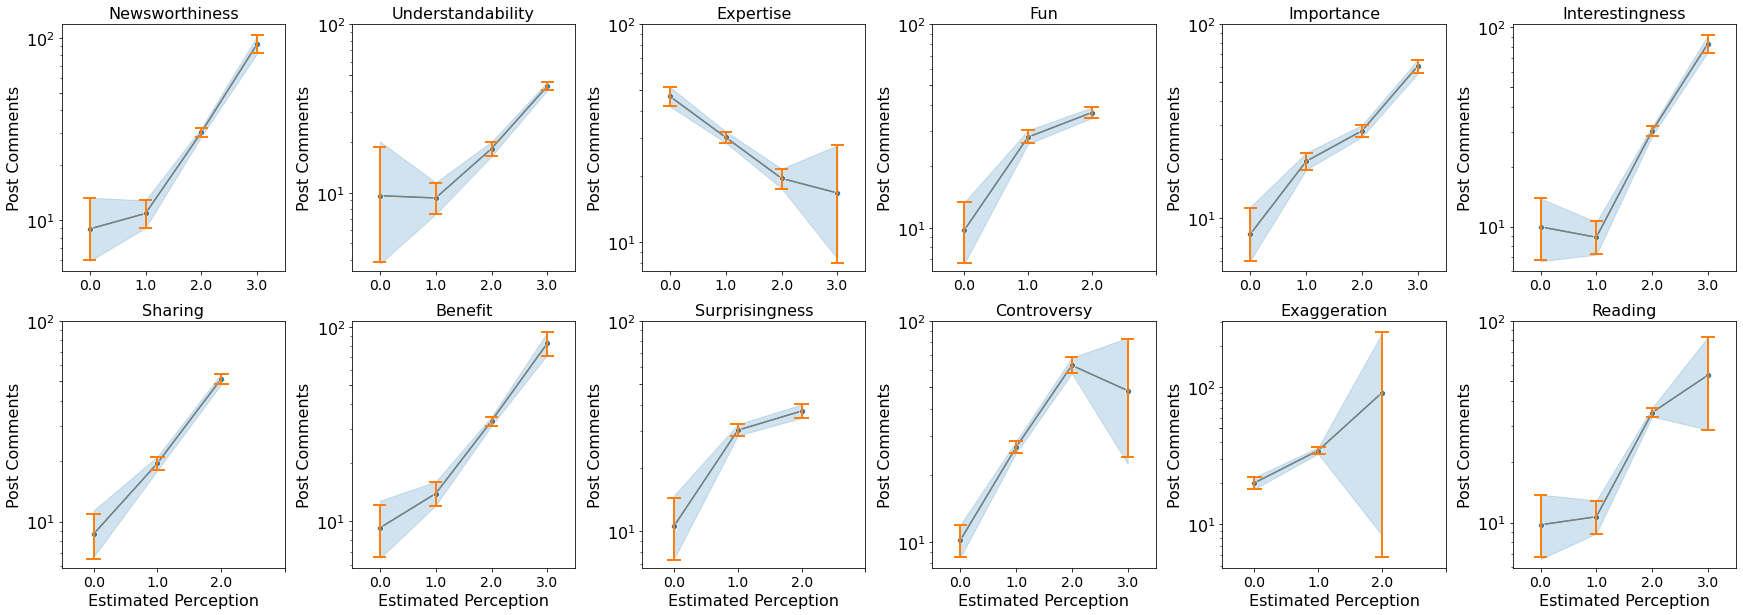

In [974]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 6, figsize=(30, 10))  # Create a 2x6 plot grid
plt.subplots_adjust(wspace=0.3, hspace=0.2)  # Adjust the horizontal and vertical space between subplots

# Assuming statements is a list of length 12
for idx, cat in enumerate(list(statements)[:12]):
    t_df = df[(df[cat + '_cat'] < 5) & (df['len'] > 7) & (df['Surprisingness_cat'] != 3.0) & (df['Fun_cat'] != 3.0)]
    t_df['style'] = cat
    row = idx // 6  # Calculate the row index
    col = idx % 6  # Calculate the column index
    ax = sns.lineplot(x=cat + '_cat', y='num_comments', data=t_df, ax=axs[row, col], style="style", markers=True, dashes=True)
    sns.pointplot(x=cat + '_cat', y='num_comments', data=t_df, errwidth=2, capsize=0.2, linewidth=0.5, ax=ax)
    ax.set_ylabel('Post Comments', fontsize=16)
    ax.set_title(cat, fontsize=16)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yscale('log')  # Set the y-axis scale to log scale
    ax.get_legend().remove()

    if row == 1:  # Check if it's the bottom row
        ax.set_xlabel('Estimated Perception', fontsize=16)  # Set x-axis label for the bottom row only
    else:
        ax.set_xlabel('', fontsize=16)

    ax.tick_params(axis='x', labelsize=14)  # Size of x-axis tick labels
    ax.tick_params(axis='y', labelsize=16)  # Size of y-axis tick labels

    # Add more y-axis tick labels
    yticklabels = [10, 50, 100]  # Customize these as needed
    ax.set_yticks(yticklabels)

plt.savefig('../shared_data/figures/reddit_comment_perception_pointplot.pdf', bbox_inches='tight')

<ipython-input-967-43c14b4db39e>:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.pointplot(x=cat + '_cat', y='score', data=t_df, ax=axs[row, col], errwidth=2, capsize=0.2, linewidth=0.5)
<ipython-input-967-43c14b4db39e>:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.pointplot(x=cat + '_cat', y='score', data=t_df, ax=axs[row, col], errwidth=2, capsize=0.2, linewidth=0.5)
<ipython-input-967-43c14b4db39e>:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.pointplot(x=cat + '_cat', y='score', data=t_df, ax=axs[row, col], errwidth=2, capsize=0.2, linewidth=0.5)
<ipython-input-967-43c14b4db39e>:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'lin

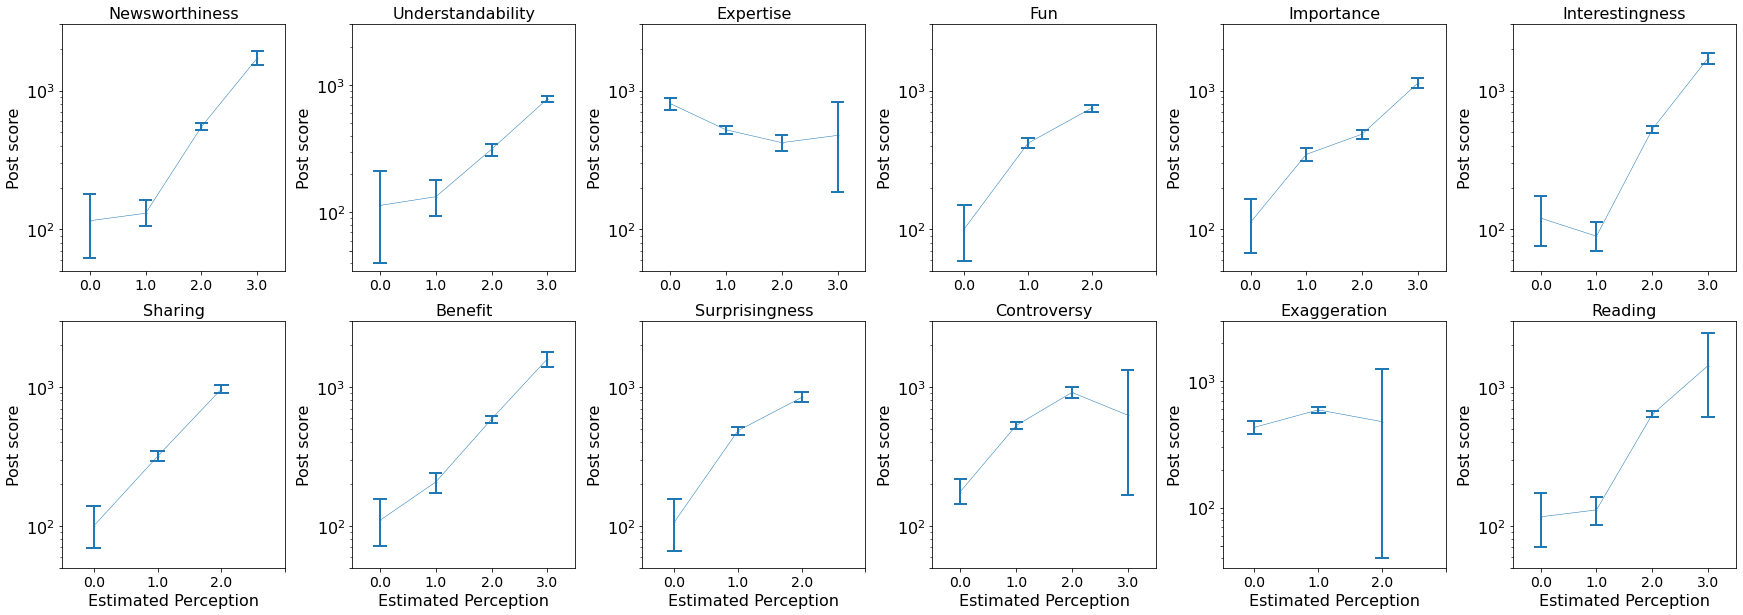

In [967]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 6, figsize=(30, 10))  # Create a 2x6 plot grid
plt.subplots_adjust(wspace=0.3, hspace=0.2)  # Adjust the horizontal and vertical space between subplots

# Assuming statements is a list of length 12
for idx, cat in enumerate(list(statements)[:12]):
    t_df = df[(df[cat + '_cat'] < 5) & (df['len'] > 7) & (df['Surprisingness_cat'] != 3.0) & (df['Fun_cat'] != 3.0)]
    row = idx // 6  # Calculate the row index
    col = idx % 6  # Calculate the column index
    ax = sns.pointplot(x=cat + '_cat', y='score', data=t_df, ax=axs[row, col], errwidth=2, capsize=0.2, linewidth=0.5)
    ax.set_ylabel('Post score', fontsize=16)
    ax.set_title(cat, fontsize=16)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yscale('log')  # Set the y-axis scale to log scale

    if row == 1:  # Check if it's the bottom row
        ax.set_xlabel('Estimated Perception', fontsize=16)  # Set x-axis label for the bottom row only
    else:
        ax.set_xlabel('', fontsize=16)

    ax.tick_params(axis='x', labelsize=14)  # Size of x-axis tick labels
    ax.tick_params(axis='y', labelsize=16)  # Size of y-axis tick labels

    # Add more y-axis tick labels
    yticklabels = [50, 100, 1000, 3000]  # Customize these as needed
    ax.set_yticks(yticklabels)

plt.savefig('../shared_data/figures/reddit_score_perception_pointplot.pdf', bbox_inches='tight')

<ipython-input-968-32405b65c4ed>:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.pointplot(x=cat + '_cat', y='num_comments', data=t_df, ax=axs[row, col], errwidth=2, capsize=0.2, linewidth=0.5)
<ipython-input-968-32405b65c4ed>:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.pointplot(x=cat + '_cat', y='num_comments', data=t_df, ax=axs[row, col], errwidth=2, capsize=0.2, linewidth=0.5)
<ipython-input-968-32405b65c4ed>:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 2}` instead.

  ax = sns.pointplot(x=cat + '_cat', y='num_comments', data=t_df, ax=axs[row, col], errwidth=2, capsize=0.2, linewidth=0.5)
<ipython-input-968-32405b65c4ed>:12: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0

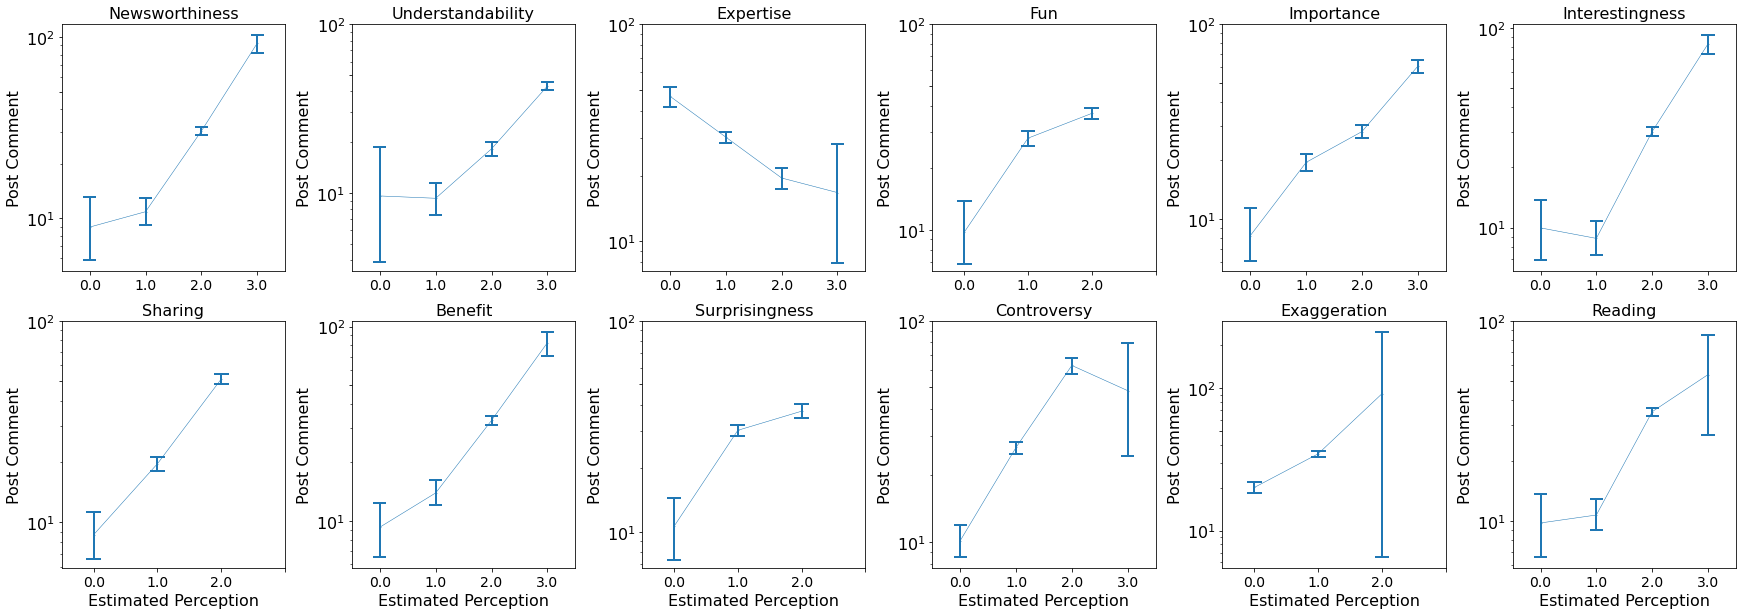

In [968]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 6, figsize=(30, 10))  # Create a 2x6 plot grid
plt.subplots_adjust(wspace=0.3, hspace=0.2)  # Adjust the horizontal and vertical space between subplots

# Assuming statements is a list of length 12
for idx, cat in enumerate(list(statements)[:12]):
    t_df = df[(df[cat + '_cat'] < 5) & (df['len'] > 7) & (df['Surprisingness_cat'] != 3.0) & (df['Fun_cat'] != 3.0)]
    row = idx // 6  # Calculate the row index
    col = idx % 6  # Calculate the column index
    ax = sns.pointplot(x=cat + '_cat', y='num_comments', data=t_df, ax=axs[row, col], errwidth=2, capsize=0.2, linewidth=0.5)
    ax.set_ylabel('Post Comment', fontsize=16)
    ax.set_title(cat, fontsize=16)
    ax.set_xticks([0, 1, 2, 3])
    ax.set_yscale('log')  # Set the y-axis scale to log scale

    if row == 1:  # Check if it's the bottom row
        ax.set_xlabel('Estimated Perception', fontsize=16)  # Set x-axis label for the bottom row only
    else:
        ax.set_xlabel('', fontsize=16)

    ax.tick_params(axis='x', labelsize=14)  # Size of x-axis tick labels
    ax.tick_params(axis='y', labelsize=16)  # Size of y-axis tick labels

    # Add more y-axis tick labels
    yticklabels = [10, 50, 100]  # Customize these as needed
    ax.set_yticks(yticklabels)

plt.savefig('../shared_data/figures/reddit_comment_perception_pointplot.pdf', bbox_inches='tight')

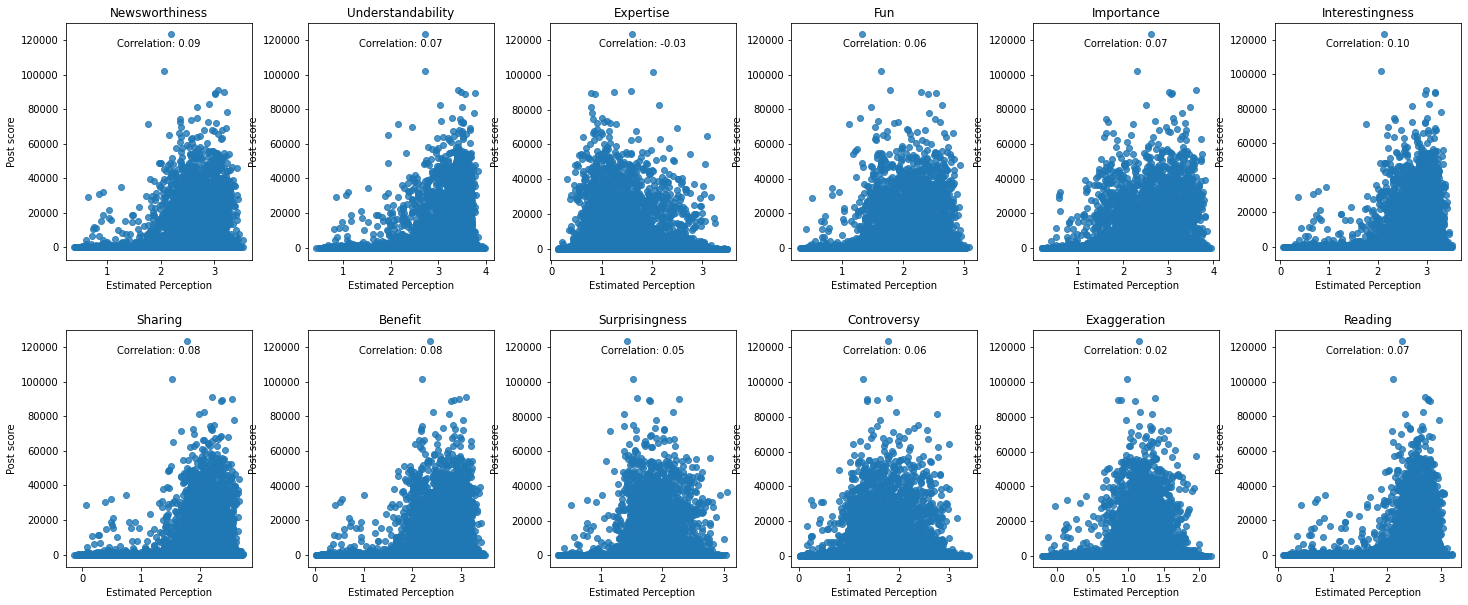

In [740]:
fig, axs = plt.subplots(2, 6, figsize=(25, 10))  # Create a 2x6 plot grid
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust the horizontal and vertical space between subplots

for idx, cat in enumerate(list(statements)[:12]):
    row = idx // 6  # Calculate the row index
    col = idx % 6  # Calculate the column index
    ax = sns.regplot(x=cat, y='score', data=df[(df[cat] < 5) & (df['len'] > 7)], ax=axs[row, col], scatter=True)
    ax.set_ylabel('Post score')
    ax.set_xlabel(f'Estimated Perception')
    ax.set_title(f'{cat}')

    # Calculate correlation coefficient
    correlation = df[(df[cat] < 5) & (df['len'] > 7)][[cat, 'score']].corr().iloc[0, 1]
    ax.annotate(f'Correlation: {correlation:.2f}', xy=(0.5, 0.9), xycoords='axes fraction', ha='center')

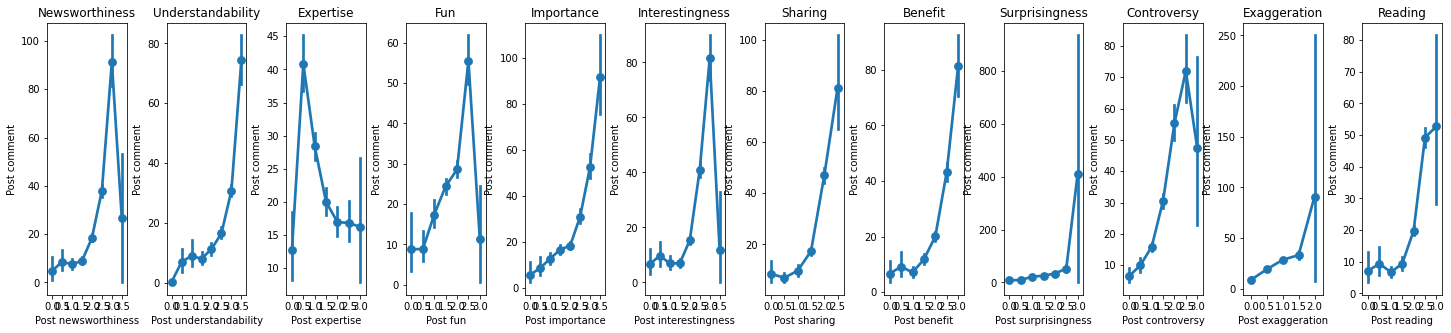

In [622]:
fig, axs = plt.subplots(1, len(statements), figsize=(25, 5))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots
for idx, cat in enumerate(list(statements)[:]):
    ax = sns.pointplot(x=cat + '_cat', y='num_comments', data=df[df[cat + '_cat'] < 4], ax=axs[idx])
    ax.set_ylabel('Post comment')
    ax.set_xlabel(f'Post {cat.lower()}')
    ax.set_title(f'{cat}')

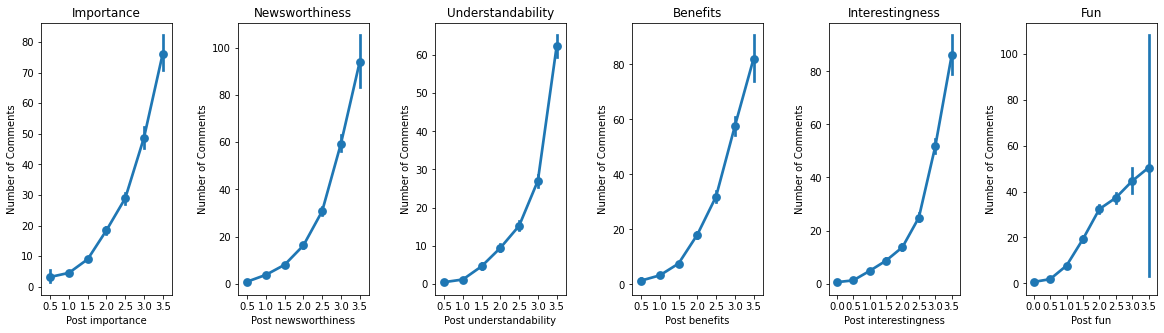

In [97]:
fig, axs = plt.subplots(1, len(sel_statements)-2, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)  # Adjust the horizontal space between subplots
for idx, cat in enumerate(list(sel_statements.values())[:-2]):
    ax = sns.pointplot(x=cat + '_cat', y='num_comments', data=df[df[cat + '_cat'] < 4], ax=axs[idx])
    ax.set_ylabel('Number of Comments')
    ax.set_xlabel(f'Post {cat.lower()}')
    ax.set_title(f'{cat}')

In [ ]:
#sns.set(style="white", color_codes=True)
sns.jointplot(x='score', y='Newsworthiness', data=df, kind="kde", color="skyblue")

Text(0.5, 0, 'Post newsworthiness')

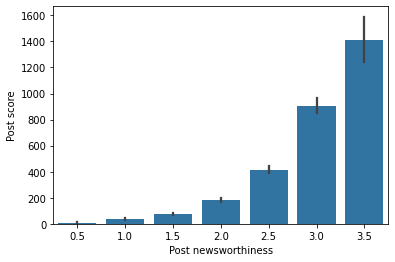

In [29]:
# Create barplot with primary y-axis
ax = sns.barplot(x='Newsworthiness_cat', y='score', data=df[df.Newsworthiness_cat != 4])
ax.set_ylabel('Post score')
ax.set_xlabel('Post newsworthiness')

# Create a secondary y-axis for distribution of Newsworthiness_cat
#ax2 = ax.twinx()

# Plot the distribution
#sns.histplot(data=df, x='Newsworthiness_cat', ax=ax2, color='orange')

# Remove y-axis label from the secondary y-axis
#ax2.set_ylabel('Number of posts (Orange bar)')

Text(0, 0.5, 'Number of posts (Orange bar)')

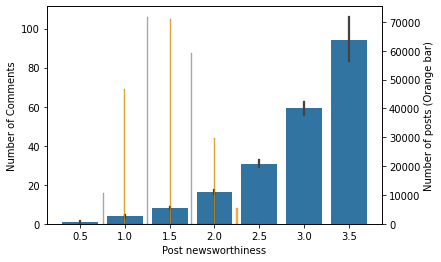

In [28]:
# Create barplot with primary y-axis
ax = sns.barplot(x='Newsworthiness_cat', y='num_comments', data=df[df.Newsworthiness_cat != 4])
ax.set_ylabel('Number of Comments')
ax.set_xlabel('Post newsworthiness')

# Create a secondary y-axis for distribution of Newsworthiness_cat
ax2 = ax.twinx()

# Plot the distribution
sns.histplot(data=df, x='Newsworthiness_cat', ax=ax2, color='orange')

# Remove y-axis label from the secondary y-axis
ax2.set_ylabel('Number of posts (Orange bar)')

,score_cat,count
0,1,153387
1,2-5,33028
2,0,27391
3,100+,21298
4,6-10,17451
5,11-20,15884
6,31-50,9063
7,51-100,8727
8,21-30,8645


Text(0.5, 0, 'Reddit Post Score')

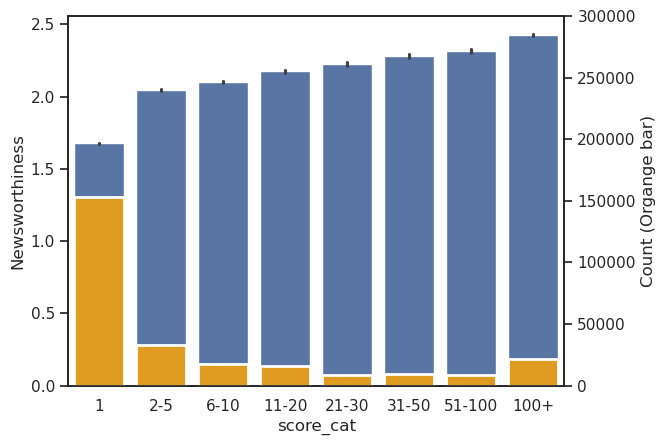

In [190]:
# Create barplot with primary y-axis
ax = sns.barplot(x='score_cat', y='Newsworthiness', data=df[df['score']!=0], order = ['1', '2-5', '6-10', '11-20', '21-30', '31-50', '51-100', '100+'])

# Create a secondary y-axis for distribution of score_cat
ax2 = ax.twinx()

# Plot the distribution
sns.countplot(data=df[df['score']!=0], x='score_cat', ax=ax2, color='orange', linestyle='-', linewidth=2, order = [ '1', '2-5', '6-10', '11-20', '21-30', '31-50', '51-100', '100+'])

#sns.lineplot(data=df.score_cat.value_counts().reset_index(), x='score_cat',y='count', ax=ax2, color='orange', order = ['0', '1', '2-5', '6-10', '11-20', '21-30', '31-50', '51-100', '100+'])

ax2.set_ylim(0, 300000)
# Remove y-axis label from the secondary y-axis
ax2.set_ylabel('Count (Organge bar)')

plt.xlabel('Reddit Post Score')

In [183]:
df.Newsworthiness.corr(df.score)


0.07414489217806165

<Axes: xlabel='num_comments_binary', ylabel='Fun'>

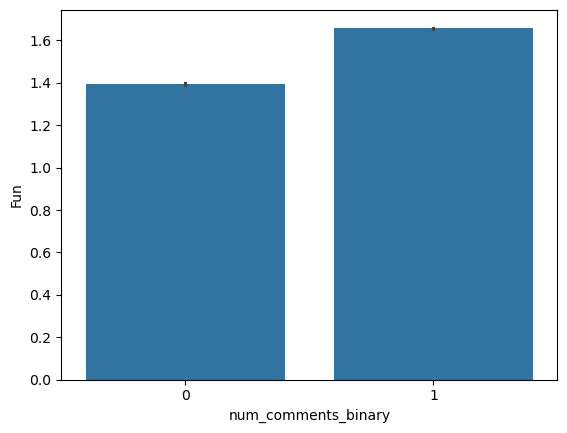

In [100]:
sns.barplot(x='num_comments_binary', y = 'Fun', data=df)

<Axes: xlabel='Interestingness', ylabel='domain'>

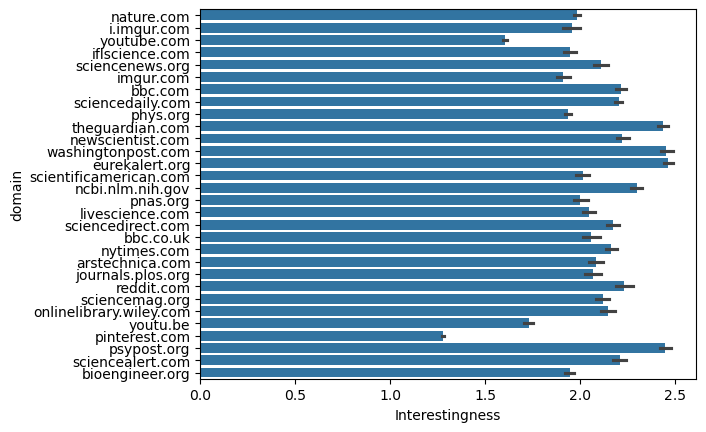

In [81]:
sns.barplot(y='domain', x='Interestingness', data=df[df['domain'].isin(top_domain)])

In [12]:
df['type']

KeyError: 'type'

In [89]:
sel_statements = {'Tackles an important issue':'Importance', 'Should be published in news':'Newsworthiness', 
                  'I understand the news story':'Understandability', 'Could benefit many people':'Benefits', 
                  'Could interest the general public':'Interestingness', 'News story is fun to read':'Fun', 
                  'Finding is surprising to me':'Surprising', 'Would share on wider forum': 'Sharing'}

<ipython-input-94-076ca8338d9d>:11: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), join=False)


<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

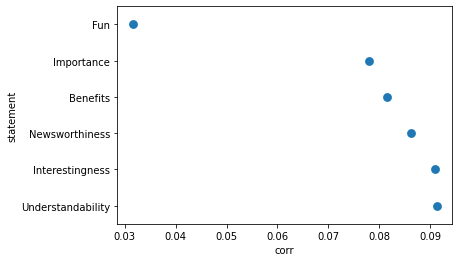

In [94]:
t_df = defaultdict(list)
for s in list(sel_statements.values())[:-2]:
    s = s.replace(' ','_')
    #print(s, df['coverage_cnt'].corr(df['sci_%s'%s]), df['coverage_cnt'].corr(df['nonsci_%s'%s]))
    t_df['statement'].append(s)
    #t_df['statement'].append(sel_statements[s.replace('_',' ')])
    a_df = df[df[s]>2]
    t_df['corr'].append(a_df['score'].corr(a_df['%s'%s]))

t_df = pd.DataFrame(t_df)
sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), join=False)
plt

In [48]:
t_df = defaultdict(list)
for s in sel_statements:
    s = s.replace(' ','_')
    #print(s, df['coverage_cnt'].corr(df['sci_%s'%s]), df['coverage_cnt'].corr(df['nonsci_%s'%s]))
    t_df['statement'].append(sel_statements[s.replace('_',' ')])
    #t_df['statement'].append(sel_statements[s.replace('_',' ')])
    t_df['corr'].append(df['score'].corr(df['all_%s'%s]))
    #t_df['corr'].append(df['score'].corr(df['nonsci_%s'%s]))
    t_df['type'].append('all')
    #t_df['type'].append('freq_sci_reader')
    #t_df['type'].append('nonfreq_sci_reader')
    #t_df['freq_sci_reader'].append(df['coverage_cnt'].corr(df['sci_%s'%s]))
    #t_df['nonfreq_sci_reader'].append(df['coverage_cnt'].corr(df['nonsci_%s'%s]))
t_df = pd.DataFrame(t_df)

<ipython-input-49-e1e53637a28e>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), join=False)


<Axes: xlabel='corr', ylabel='statement'>

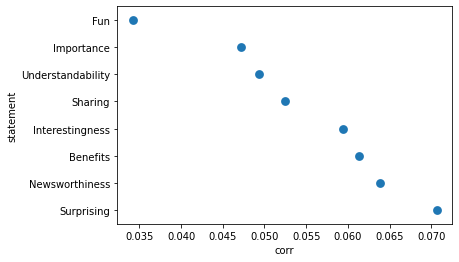

In [49]:
sns.pointplot(x='corr', y='statement', data=t_df.sort_values('corr'), join=False)

In [ ]:
df

,Unnamed: 0,retrieved_on,selftext,media,link_flair_text,permalink,title,secure_media_embed,thumbnail,distinguished,...,Newsworthiness,Understandability,Benefits,Interestingness,Fun,tgt,subject,num_comments_binary,score_cat,Newsworthiness_cat
0,0,1441288448,NaN,NaN,NaN,/r/science/comments/29iq12/in_california_droug...,"In California Drought, Desperation May Make Wa...",{},http://a.thumbs.redditmedia.com/r2JhoKPyJBRINI...,NaN,...,2.339433,2.545882,2.256766,2.112803,1.590302,41,Others,1,31-50,2.5
1,1,1441288402,NaN,NaN,NaN,/r/science/comments/29itvt/top_male_science_pr...,"Top male science professors (Nobel Laureates, ...",{},http://a.thumbs.redditmedia.com/SfSTYKXDeFrLGr...,NaN,...,2.106265,3.136231,2.280467,2.425995,1.623582,0,Others,1,0,2.0
2,2,1441288392,NaN,NaN,Anthropology,/r/science/comments/29iuhu/study_suggests_mega...,Study suggests mega-population boom among sout...,{},default,NaN,...,2.478488,3.708542,1.812304,2.709848,1.957107,0,Anthropology,0,0,2.5
3,3,1441288385,NaN,NaN,Astronomy,/r/science/comments/29iuxg/controversial_theor...,Controversial theory suggests the speed of lig...,{},default,NaN,...,1.388919,1.830466,1.326704,1.359489,1.215767,16,Astronomy,1,11-20,1.5
4,4,1441288384,NaN,NaN,NaN,/r/science/comments/29iv2l/russia_launching_po...,Russia launching powerful laser system,{},default,NaN,...,1.101225,1.191034,1.218764,0.682539,0.684532,0,Others,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294869,294869,1561252381,[deleted],NaN,NaN,/r/science/comments/bve8nu/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,NaN,...,1.237226,1.486772,1.315613,0.948815,0.917306,4,Others,1,2-5,1.0
294870,294870,1561252431,[deleted],NaN,NaN,/r/science/comments/bveca0/next_einstein_of_ou...,Next Einstein of our generation (?),{},default,NaN,...,1.965547,2.490825,1.745961,2.069073,1.769413,1,Others,1,1,2.0
294871,294871,1561252453,NaN,NaN,Geology,/r/science/comments/bvedvo/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,NaN,...,1.237226,1.486772,1.315613,0.948815,0.917306,5,Geology,1,2-5,1.0
294872,294872,1561252479,[deleted],NaN,Mathematics,/r/science/comments/bveftk/iranian_girl_scores...,Iranian girl scores higher than Einstein on Me...,{},default,NaN,...,1.222198,1.775025,1.395468,1.270755,1.303661,2,Others,1,2-5,1.0


In [19]:
df.columns

Index(['Unnamed: 0', 'retrieved_on', 'selftext', 'media', 'link_flair_text',
       'permalink', 'title', 'secure_media_embed', 'thumbnail',
       'distinguished', 'domain', 'created_utc', 'author_flair_text',
       'media_embed', 'subreddit', 'edited', 'score', 'stickied',
       'secure_media', 'url', 'subreddit_id', 'is_self', 'author',
       'link_flair_css_class', 'gilded', 'id', 'archived',
       'author_flair_css_class', 'num_comments', 'over_18',
       'author_flair_richtext', 'sci_My_social_media_feed',
       'sci_General_public', 'sci_News_story_is_interesting_to_me',
       'sci_Tackles_an_important_issue',
       'sci_Shouldnt_be_public_outside_science',
       'sci_Would_share_on_wider_forum', 'sci_News_story_is_fun_to_read',
       'sci_Finding_is_surprising_to_me', 'sci_Sci_Tech_media',
       'sci_Other_popular_media', 'sci_Policy_makers',
       'sci_Should_be_published_in_news', 'sci_Could_benefit_many_people',
       'sci_Related_industry_companies', 'sci_Findi

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
key = 'num_comments'#, 'Tackles an important issue'
df['tgt'] = df[key]
mod = ols(formula = 'tgt' + ' ~ Fun + Interestingness + Understandability + Newsworthiness + Importance + Benefits',
                      data=df)
res = mod.fit()

vif_data = pd.DataFrame()
vif_data["Variable"] = mod.exog_names
vif_data["VIF"] = [variance_inflation_factor(mod.exog, i) for i in range(mod.exog.shape[1])]
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    tgt   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     706.7
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        03:08:02   Log-Likelihood:            -1.9317e+06
No. Observations:              294874   AIC:                         3.863e+06
Df Residuals:                  294867   BIC:                         3.864e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -29.6466      1.85

In [14]:
#sns.pointplot(x='corr', y='statement', hue='type', data=t_df.sort_values('corr'), join=False)

In [49]:
def radar_plots_grid(dataframe, n_rows, n_cols, subplot_width=400, subplot_height=400, label_font_size=12):
    # Extract subject names and dimension values
    subjects = dataframe['topic']
    dimensions = list(dataframe.columns[1:])  # Assuming the dimensions start from the second column

    # Create subplots with NxM layout
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subjects, specs=[[{'type': 'polar'}]*n_cols]*n_rows)

    # Counter for the current subject
    subject_count = 0

    for i in range(1, n_rows + 1):
        for j in range(1, n_cols + 1):
            if subject_count < len(subjects):
                subject = subjects[subject_count]
                values = dataframe.loc[subject_count, dimensions].tolist()
                values += values[:1]  # Close the plot by adding the first value to the end

                trace = go.Scatterpolar(
                    r=values,
                    theta=dimensions + [dimensions[0]],  # Close the plot
                    fill='toself',
                    name=subject
                )

                fig.add_trace(trace, row=i, col=j)

                subject_count += 1

    # Customize radial axis ticks and labels
    tick_values = [0.2, 0.4, 0.6, 0.8, 1.0]  # Adjust these values as needed
    tick_labels = [f"{val:.1f}" for val in tick_values]  # Format tick labels

    for i in range(1, n_rows * n_cols + 1):
        fig.update_layout(
            polar=dict(radialaxis_tickvals=tick_values, radialaxis_ticktext=tick_labels, radialaxis_title_font_size=label_font_size)
        )

    # Update subplot layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[2, 4]  # Customize the range of the radial axis if needed
            ),
        ),
        showlegend=False,  # Remove the legend
        title_text='Radar Plots Grid',
        width=subplot_width,
        height=subplot_height
    )

    # Show the grid of radar plots
    fig.show()

def normalize_df(df):
    return (df-df.min())/(df.max()-df.min())

def radar_plot_grid(df, n, m, title=''):
    # Extract the dimension names and values
    dimensions = df.columns[1:]
    values = df[dimensions].values

    # Number of dimensions
    num_dimensions = len(dimensions)

    # Calculate the number of plots required
    num_plots = len(df)

    # Calculate the number of rows and columns in the grid
    rows = math.ceil(num_plots / m)
    cols = min(num_plots, m)

    # Create an array of evenly spaced angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, num_dimensions, endpoint=False).tolist()
    angles += angles[:1]  # Repeat the first angle to close the plot

    # Create the grid of radar plots
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10), subplot_kw={'polar': True})
    fig.subplots_adjust(hspace=0.5)

    # Loop through each subject and create a radar plot in the grid
    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            subject = df.loc[i, 'topic']
            subject_values = df.loc[i, dimensions].tolist()

            # Create a radar plot for the current subject
            ax.fill(angles, subject_values + [subject_values[0]], 'b', alpha=0.1)

            ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
            # Set the labels for the angles
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(dimensions)

            # Add the title for the current subject
            ax.set_title(f'{subject}')

    # Remove empty subplots, if any
    for i in range(num_plots, rows * cols):
        fig.delaxes(axes.flat[i])

    # Add a common title for the entire grid
    plt.suptitle(title, fontsize=22)
    
    # Show the grid of radar plots
    plt.show()

In [107]:
df

,retrieved_on,selftext,media,link_flair_text,permalink,title,secure_media_embed,thumbnail,distinguished,domain,...,nonsci_General_news_outlets,topic,Importance,Newsworthiness,Understandability,Benefits,Interestingness,Fun,tgt,subject
0,1441288448,,None,None,/r/science/comments/29iq12/in_california_droug...,"In California Drought, Desperation May Make Wa...",{},http://a.thumbs.redditmedia.com/r2JhoKPyJBRINI...,None,blogs.kqed.org,...,1.722103,Humanities,2.072511,2.339433,2.545882,2.256766,2.112803,1.590302,41,Others
1,1441288402,,None,None,/r/science/comments/29itvt/top_male_science_pr...,"Top male science professors (Nobel Laureates, ...",{},http://a.thumbs.redditmedia.com/SfSTYKXDeFrLGr...,None,slate.com,...,2.421825,other,2.129089,2.106265,3.136231,2.280467,2.425995,1.623582,0,Others
2,1441288392,,None,Anthropology,/r/science/comments/29iuhu/study_suggests_mega...,Study suggests mega-population boom among sout...,{},default,None,news.wsu.edu,...,2.900486,other,1.649891,2.478488,3.708542,1.812304,2.709848,1.957107,0,Anthropology
3,1441288385,,None,Astronomy,/r/science/comments/29iuxg/controversial_theor...,Controversial theory suggests the speed of lig...,{},default,None,datnewz.com,...,2.176565,Humanities,1.124273,1.388919,1.830466,1.326704,1.359489,1.215767,16,Astronomy
4,1441288384,,None,None,/r/science/comments/29iv2l/russia_launching_po...,Russia launching powerful laser system,{},default,None,panicatech.com,...,1.776282,Humanities,1.194327,1.101225,1.191033,1.218764,0.682539,0.684532,0,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294869,1561252381,[deleted],None,None,/r/science/comments/bve8nu/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,None,sciencedirect.com,...,2.046151,Humanities,1.329057,1.237226,1.486772,1.315613,0.948815,0.917306,4,Others
294870,1561252431,[deleted],None,None,/r/science/comments/bveca0/next_einstein_of_ou...,Next Einstein of our generation (?),{},default,None,nextshark.com,...,2.258176,Humanities,1.775899,1.965547,2.490825,1.745960,2.069073,1.769413,1,Others
294871,1561252453,,None,Geology,/r/science/comments/bvedvo/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,None,sciencedirect.com,...,2.046151,Humanities,1.329057,1.237226,1.486772,1.315613,0.948815,0.917306,5,Geology
294872,1561252479,[deleted],None,Mathematics,/r/science/comments/bveftk/iranian_girl_scores...,Iranian girl scores higher than Einstein on Me...,{},default,None,nextshark.com,...,1.797426,Biology,1.204250,1.222198,1.775025,1.395468,1.270755,1.303661,2,Others


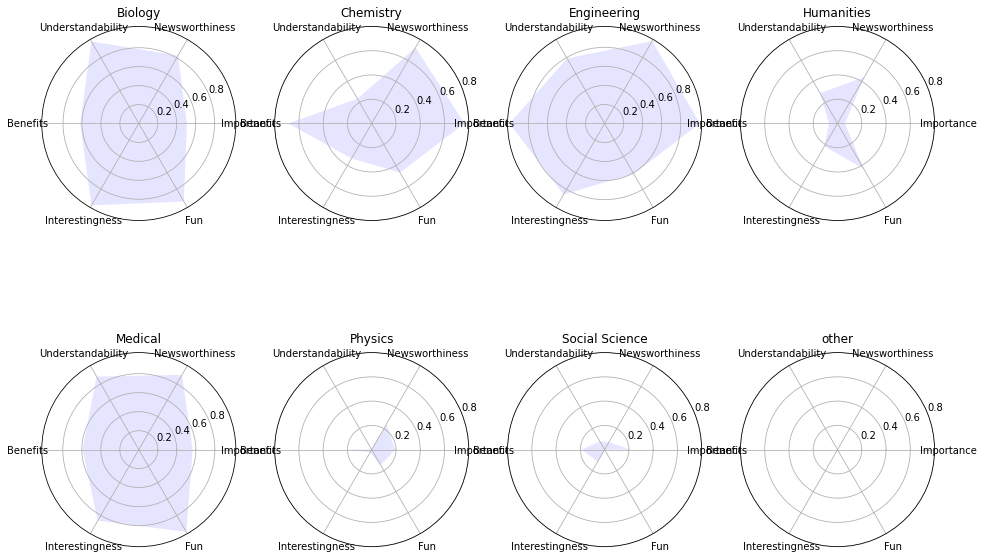

In [106]:
for s in sel_statements:
    s = s.replace(' ','_')
    df[sel_statements[s.replace('_', ' ')]] = df['sci_' + s] 
t_df = normalize_df(df[['topic'] + list(sel_statements.values())].groupby('topic').mean()).reset_index()
t_df = t_df.reset_index().drop(columns=['index'])
#radar_plots_grid(t_df, 4,4, 1000, 1000, 1)
radar_plot_grid(t_df, 4, 4)

In [80]:
subjects = set(df.link_flair_text.value_counts()[:20].index)
df['subject'] = [it if it in subjects else 'Others' for it in df.link_flair_text]

In [99]:
list(df.link_flair_text.value_counts()[:20].index)

['Health',
 'Biology',
 'Medicine',
 'Environment',
 'Astronomy',
 'Psychology',
 'Neuroscience',
 'Physics',
 'Animal Science',
 'Engineering',
 'Social Science',
 'Earth Science',
 'Cancer',
 'Chemistry',
 'Computer Science',
 'Anthropology',
 'Paleontology',
 'Geology',
 'Epidemiology',
 'Nanoscience']

Importance
Newsworthiness
Understandability
Benefits
Interestingness
Fun


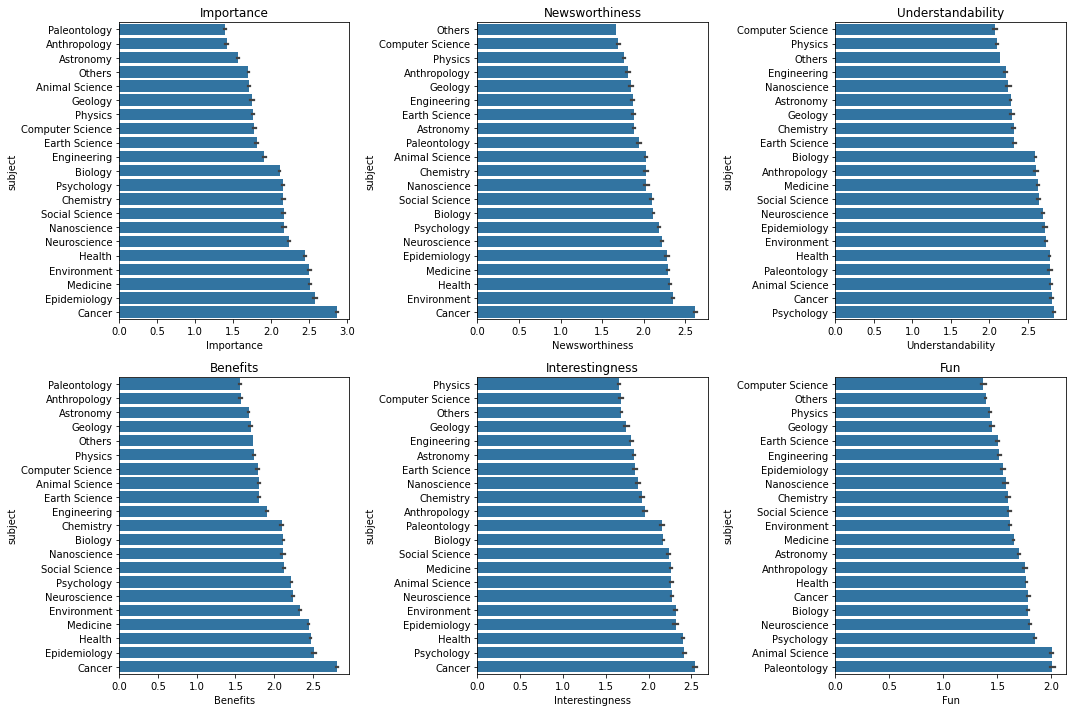

In [89]:
num_rows = 2
num_cols = 3

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the keys and create bar plots
for idx, (_, key) in enumerate(sel_statements.items()):
    print(key)
    ax = axes[idx]  # Get the current subplot
    sns.barplot(y='subject', x=key, data=df, order=list(df[['subject', key]].groupby('subject').mean().sort_values(key).index), ax=ax)
    ax.set_title(key)  # Set the title for the subplot

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

<Axes: xlabel='count', ylabel='subject'>

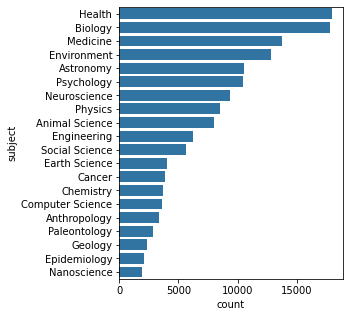

In [103]:
fig, axes = plt.subplots(figsize=(4, 5))
sns.countplot(y='subject',data=df, order=list(df.link_flair_text.value_counts()[:20].index))

In [117]:
df.groupby('link_flair_text').count().reset_index().sort_values('retrieved_on')

,link_flair_text,retrieved_on,selftext,media,permalink,title,secure_media_embed,thumbnail,distinguished,domain,...,nonsci_General_news_outlets,topic,Importance,Newsworthiness,Understandability,Benefits,Interestingness,Fun,tgt,subject
0,(PDF) Earth Science,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
604,Net Neutrality,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
605,Neurobiology AMA,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
606,Neurobiology Of Addictive Disorders AMA,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
607,Neuroengineering AMA,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Astronomy,10562,10562,566,10562,10562,10562,10562,3,10562,...,10562,10562,10562,10562,10562,10562,10562,10562,10562,10562
307,Environment,12828,12828,332,12828,12828,12828,12828,1,12828,...,12828,12828,12828,12828,12828,12828,12828,12828,12828,12828
530,Medicine,13781,13781,197,13781,13781,13781,13781,0,13781,...,13781,13781,13781,13781,13781,13781,13781,13781,13781,13781
87,Biology,17806,17806,415,17806,17806,17806,17806,2,17806,...,17806,17806,17806,17806,17806,17806,17806,17806,17806,17806


In [130]:
df.columns

Index(['retrieved_on', 'selftext', 'media', 'link_flair_text', 'permalink',
       'title', 'secure_media_embed', 'thumbnail', 'distinguished', 'domain',
       'created_utc', 'author_flair_text', 'media_embed', 'subreddit',
       'edited', 'score', 'stickied', 'secure_media', 'url', 'subreddit_id',
       'is_self', 'author', 'link_flair_css_class', 'gilded', 'id', 'archived',
       'author_flair_css_class', 'num_comments', 'over_18',
       'author_flair_richtext', 'sci_My_social_media_feed',
       'sci_General_public', 'sci_News_story_is_interesting_to_me',
       'sci_Tackles_an_important_issue',
       'sci_Shouldnt_be_public_outside_science',
       'sci_Would_share_on_wider_forum', 'sci_News_story_is_fun_to_read',
       'sci_Finding_is_surprising_to_me', 'sci_Sci_Tech_media',
       'sci_Other_popular_media', 'sci_Policy_makers',
       'sci_Should_be_published_in_news', 'sci_Could_benefit_many_people',
       'sci_Related_industry_companies', 'sci_Finding_could_be_controver

In [78]:
for idx, (_, key) in enumerate(sel_statements.items()):
    print(key, df[key].corr(df['score']))

NameError: name 'sel_statements' is not defined

In [118]:
df['field_cnt'] = df.groupby('link_flair_text').transform('count').reset_index()['retrieved_on']

In [110]:
top_fields = list(df.link_flair_text.value_counts()[:20].index)


In [122]:
t_df = df[df['link_flair_text'].isin(top_fields)][['link_flair_text', 'field_cnt', 'Newsworthiness', 'score']].groupby('link_flair_text').mean().reset_index()

In [125]:
df.Newsworthiness.corr(df.field_cnt)

0.15035985527216397

In [126]:
df.Newsworthiness.corr(df.score)

0.10133419475608664

In [108]:
fig, axes = plt.subplots(figsize=(4, 4))
plt.text(0,80, 'Corr = 0.08', color='red')
sns.scatterplot(y='coverage_cnt', x='doi_newsworthiness', data=df.drop_duplicates('doi'),ax=axes)
plt.xlabel('Paper Newsworthiness')
plt.ylabel('Coverage Count')
#plt.savefig('../shared_data/figures/coverage_cnt_value_ranking_article_hist.pdf', bbox_inches='tight')

,retrieved_on,selftext,media,link_flair_text,permalink,title,secure_media_embed,thumbnail,distinguished,domain,...,nonsci_General_news_outlets,topic,Importance,Newsworthiness,Understandability,Benefits,Interestingness,Fun,tgt,subject
0,1441288448,,None,None,/r/science/comments/29iq12/in_california_droug...,"In California Drought, Desperation May Make Wa...",{},http://a.thumbs.redditmedia.com/r2JhoKPyJBRINI...,None,blogs.kqed.org,...,1.722103,Humanities,2.072511,2.339433,2.545882,2.256766,2.112803,1.590302,41,Others
1,1441288402,,None,None,/r/science/comments/29itvt/top_male_science_pr...,"Top male science professors (Nobel Laureates, ...",{},http://a.thumbs.redditmedia.com/SfSTYKXDeFrLGr...,None,slate.com,...,2.421825,other,2.129089,2.106265,3.136231,2.280467,2.425995,1.623582,0,Others
2,1441288392,,None,Anthropology,/r/science/comments/29iuhu/study_suggests_mega...,Study suggests mega-population boom among sout...,{},default,None,news.wsu.edu,...,2.900486,other,1.649891,2.478488,3.708542,1.812304,2.709848,1.957107,0,Anthropology
3,1441288385,,None,Astronomy,/r/science/comments/29iuxg/controversial_theor...,Controversial theory suggests the speed of lig...,{},default,None,datnewz.com,...,2.176565,Humanities,1.124273,1.388919,1.830466,1.326704,1.359489,1.215767,16,Astronomy
4,1441288384,,None,None,/r/science/comments/29iv2l/russia_launching_po...,Russia launching powerful laser system,{},default,None,panicatech.com,...,1.776282,Humanities,1.194327,1.101225,1.191033,1.218764,0.682539,0.684532,0,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294869,1561252381,[deleted],None,None,/r/science/comments/bve8nu/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,None,sciencedirect.com,...,2.046151,Humanities,1.329057,1.237226,1.486772,1.315613,0.948815,0.917306,4,Others
294870,1561252431,[deleted],None,None,/r/science/comments/bveca0/next_einstein_of_ou...,Next Einstein of our generation (?),{},default,None,nextshark.com,...,2.258176,Humanities,1.775899,1.965547,2.490825,1.745960,2.069073,1.769413,1,Others
294871,1561252453,,None,Geology,/r/science/comments/bvedvo/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,None,sciencedirect.com,...,2.046151,Humanities,1.329057,1.237226,1.486772,1.315613,0.948815,0.917306,5,Geology
294872,1561252479,[deleted],None,Mathematics,/r/science/comments/bveftk/iranian_girl_scores...,Iranian girl scores higher than Einstein on Me...,{},default,None,nextshark.com,...,1.797426,Biology,1.204250,1.222198,1.775025,1.395468,1.270755,1.303661,2,Others


In [193]:
df.columns

Index(['Unnamed: 0', 'retrieved_on', 'selftext', 'media', 'link_flair_text',
       'permalink', 'title', 'secure_media_embed', 'thumbnail',
       'distinguished', 'domain', 'created_utc', 'author_flair_text',
       'media_embed', 'subreddit', 'edited', 'score', 'stickied',
       'secure_media', 'url', 'subreddit_id', 'is_self', 'author',
       'link_flair_css_class', 'gilded', 'id', 'archived',
       'author_flair_css_class', 'num_comments', 'over_18',
       'author_flair_richtext', 'sci_My_social_media_feed',
       'sci_General_public', 'sci_News_story_is_interesting_to_me',
       'sci_Tackles_an_important_issue',
       'sci_Shouldnt_be_public_outside_science',
       'sci_Would_share_on_wider_forum', 'sci_News_story_is_fun_to_read',
       'sci_Finding_is_surprising_to_me', 'sci_Sci_Tech_media',
       'sci_Other_popular_media', 'sci_Policy_makers',
       'sci_Should_be_published_in_news', 'sci_Could_benefit_many_people',
       'sci_Related_industry_companies', 'sci_Findi

In [ ]:
key = 'num_comments_binary'#, 'Tackles an important issue'
df['tgt'] = df[key]
mod = ols(formula = 'tgt' + ' ~ Newsworthiness + topic + domain',
                      data=df)
res = mod.fit()
print(res.summary())

In [48]:
data_df[:30000].to_csv('../data/reddit_science_30k.csv',index=False)

In [101]:
data_df = pd.read_csv('../data/reddit_science_30k_with_topic.csv')

In [21]:
#data_df['category_cnt'] = [len(eval(it)) for it in data_df['pred_labels']]
#data_df = data_df[data_df['category_cnt']==1]
#data_df['category_cnt'].value_counts()

In [103]:
data_df['topic'] = ['other' if len(eval(it)) == 0 else eval(it)[0] for it in data_df['pred_labels']]
data_df['topic'].value_counts()

other             10284
Physics            5666
Engineering        4989
Biology            3312
Medical            1879
Chemistry          1808
Social Science     1198
Humanities          864
Name: topic, dtype: int64

In [100]:
data_df['link_flair_text']

0                 NaN
3           Astronomy
4                 NaN
7            Medicine
8                 NaN
             ...     
29993             NaN
29994             NaN
29995             NaN
29997             NaN
29998    Neuroscience
Name: link_flair_text, Length: 17744, dtype: object

In [115]:
subjects = set(data_df.link_flair_text.value_counts()[:20].index)

<AxesSubplot:xlabel='score', ylabel='link_flair_text'>

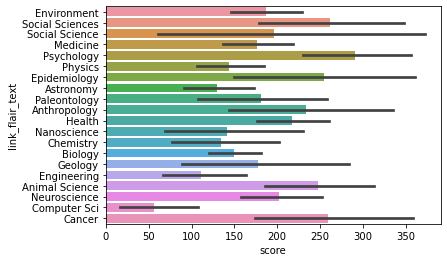

In [113]:
sns.barplot(y='link_flair_text',x='score',data=data_df, order = list(set(data_df.link_flair_text.value_counts()[:20].index)))

<AxesSubplot:xlabel='count', ylabel='link_flair_text'>

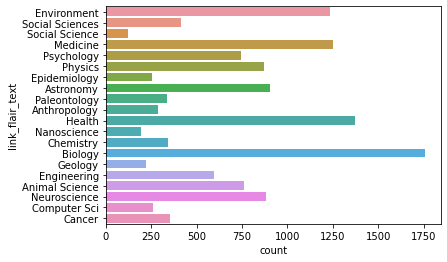

In [114]:
sns.countplot(y='link_flair_text',data=data_df, order = list(set(data_df.link_flair_text.value_counts()[:20].index)))

In [121]:
t_df = data_df[data_df.link_flair_text.isin(subjects)]
t_df['split'] = split_labels(len(t_df))
t_df.to_csv('../data/reddit_science_train.csv',index=False)

<ipython-input-121-b28564724568>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['split'] = split_labels(len(t_df))


<AxesSubplot:xlabel='score', ylabel='topic'>

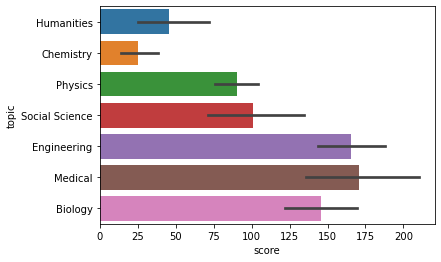

In [97]:
sns.barplot(y='topic',x='score',data=data_df, order=['Humanities', 'Chemistry', 'Physics', 'Social Science', 'Engineering', 'Medical', 'Biology'])

<AxesSubplot:xlabel='count', ylabel='topic'>

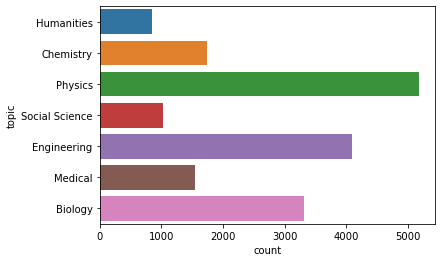

In [98]:
sns.countplot(y='topic',data=data_df, order=['Humanities', 'Chemistry', 'Physics', 'Social Science', 'Engineering', 'Medical', 'Biology'])